Notebook for applying model output statistics to Global Forecasting System (GFS) model data based on in-situ wind speed observations from the summit of Mt Everest.

In [1]:
#Import relevant packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import hydroeval as hy
import xarray as xr
import scipy
from scipy import stats
from datetime import datetime, timedelta
import pickle
from scipy.stats import skew
from scipy.stats import kurtosis
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import RocCurveDisplay

# Increase the size of plots from the default for visibility
plt.rcParams['figure.figsize'] = [10, 5]

#Suppress warnings (particularly useful where looped downloads can trigger many unnecessary warnings. May want to be commented out for diagnosing errors).
import warnings
warnings.filterwarnings("ignore")

In [2]:
######## Define some necessary functions
def windget(u,v):
    #Create wind speed and wind direction
    wind_abs = np.sqrt(u*u + v*v)
    wind_dir = (270-np.rad2deg(np.arctan2(v,u))) % 360

    return(wind_abs,wind_dir)

def GFSresamp(tlag,GFSx):
    DF=GFSx;GFSxws,GFSxwd=windget(DF['Usummit'],DF['Vsummit'])
    D = pd.DataFrame()
    D['ws'+tlag] = GFSxws
    D['wd'+tlag] = GFSxwd
    D = D.set_index(pd.to_datetime(GFSx['forecast_time']))
    D = D[~D.index.duplicated()]
    D=D.resample('H').interpolate()
    D=D[(D.index > '2019-03-31 23:59')& (D.index < '2023-01-01')];
    return(D)

def dualcorrplot(label1,label2,cwindow,window,a,b,time):
    a.interpolate();b.interpolate()

    DF = pd.DataFrame()
    DF['a'] = a
    DF['b'] = b
    fig=plt.figure()
    ax1=fig.add_subplot(211)
    DF = DF.set_index(time)
    DF=DF.dropna()
    ax1.plot(DF.index,DF['a'].rolling(window).mean(), color="black",linewidth=0.5, label = label1)

    ax1.plot(DF.index,DF['b'].rolling(window).mean(), color="red",linewidth=0.5, label = label2)

    # ax1.gcf().autofmt_xdate()
    ax1.grid(linewidth = 0.5, alpha = 0.5)
    # ax1.title(title)
    ax1.set_ylabel("Wind speed (m/s)")
    ax1.legend()
    # ax1.set_xlim(['2019-01-01 00:00:00','2022-12-31 23:00:00'])

    ax2=fig.add_subplot(212)
    ds1=DF['a'];ds2=DF['b'];
    dts=DF.index;
    corr_roll=ds1.rolling(cwindow).corr(ds2,method='spearman');
    # print(corr_roll.dropna())

    DF=pd.DataFrame();DF['a']=corr_roll;DF=DF.set_index(dts);
    ax2.plot(DF.index,DF['a'].rolling(window).mean(), color="black");
    plt.gcf().autofmt_xdate();
    # ax2.title(title);
    ax2.set_ylabel('Correlation score');
    ax2.set_ylim([-1.1, 1.1]);ax2.grid(linewidth = 0.5, alpha = 0.5);
    plt.show

def mykge(simulations, evaluation):
    """Original Kling-Gupta Efficiency (KGE) and its three components
    (r, α, β) as per `Gupta et al., 2009
    <https://doi.org/10.1016/j.jhydrol.2009.08.003>`_.
    Note, all four values KGE, r, α, β are returned, in this order.
    :Calculation Details:
        .. math::
           E_{\\text{KGE}} = 1 - \\sqrt{[r - 1]^2 + [\\alpha - 1]^2
           + [\\beta - 1]^2}
        .. math::
           r = \\frac{\\text{cov}(e, s)}{\\sigma({e}) \\cdot \\sigma(s)}
        .. math::
           \\alpha = \\frac{\\sigma(s)}{\\sigma(e)}
        .. math::
           \\beta = \\frac{\\mu(s)}{\\mu(e)}
        where *e* is the *evaluation* series, *s* is (one of) the
        *simulations* series, *cov* is the covariance, *σ* is the
        standard deviation, and *μ* is the arithmetic mean.
    """
    # calculate error in timing and dynamics r
    # (Pearson's correlation coefficient)
    sim_mean = np.mean(simulations, axis=0)
    obs_mean = np.mean(evaluation)

    r_num = np.sum((simulations - sim_mean) * (evaluation - obs_mean),
                   axis=0)
    r_den = np.sqrt(np.sum((simulations - sim_mean) ** 2,
                           axis=0)
                    * np.sum((evaluation - obs_mean) ** 2))
    r = r_num / r_den
    # calculate error in spread of flow alpha
    alpha = np.std(simulations, axis=0) / np.std(evaluation)
    # calculate error in volume beta (bias of mean discharge)
    beta = (np.sum(simulations, axis=0)
            / np.sum(evaluation))
    # calculate the Kling-Gupta Efficiency KGE
    kge_ = 1 - np.sqrt((r - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2)

    return [kge_, r, alpha, beta]

def mykgesimple(simulations, evaluation,ovar):
    """Original Kling-Gupta Efficiency (KGE) and its three components
    (r, α, β) as per `Gupta et al., 2009
    <https://doi.org/10.1016/j.jhydrol.2009.08.003>`_.
    Note, all four values KGE, r, α, β are returned, in this order.
    :Calculation Details:
        .. math::
           E_{\\text{KGE}} = 1 - \\sqrt{[r - 1]^2 + [\\alpha - 1]^2
           + [\\beta - 1]^2}
        .. math::
           r = \\frac{\\text{cov}(e, s)}{\\sigma({e}) \\cdot \\sigma(s)}
        .. math::
           \\alpha = \\frac{\\sigma(s)}{\\sigma(e)}
        .. math::
           \\beta = \\frac{\\mu(s)}{\\mu(e)}
        where *e* is the *evaluation* series, *s* is (one of) the
        *simulations* series, *cov* is the covariance, *σ* is the
        standard deviation, and *μ* is the arithmetic mean.
    """
    # calculate error in timing and dynamics r
    # (Pearson's correlation coefficient)
    sim_mean = np.mean(simulations, axis=0)
    obs_mean = np.mean(evaluation)

    r_num = np.sum((simulations - sim_mean) * (evaluation - obs_mean),
                   axis=0)
    r_den = np.sqrt(np.sum((simulations - sim_mean) ** 2,
                           axis=0)
                    * np.sum((evaluation - obs_mean) ** 2))
    r = r_num / r_den
    # calculate error in spread of flow alpha
    alpha = np.std(simulations, axis=0) / np.std(evaluation)
    # calculate error in volume beta (bias of mean discharge)
    beta = (np.sum(simulations, axis=0)
            / np.sum(evaluation))
    # calculate the Kling-Gupta Efficiency KGE
    kge_ = 1 - np.sqrt((r - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2)
    
    if ovar==1:
        kge_=kge_
    elif ovar==2:
        kge_=r
    elif ovar==3:
        kge_=alpha
    elif ovar==4:
        kge_=beta
        
        
    return kge_

def mynse(simulations, evaluation):
    """Nash-Sutcliffe Efficiency (NSE) as per `Nash and Sutcliffe, 1970
    <https://doi.org/10.1016/0022-1694(70)90255-6>`_.
    :Calculation Details:
        .. math::
           E_{\\text{NSE}} = 1 - \\frac{\\sum_{i=1}^{N}[e_{i}-s_{i}]^2}
           {\\sum_{i=1}^{N}[e_{i}-\\mu(e)]^2}
        where *N* is the length of the *simulations* and *evaluation*
        periods, *e* is the *evaluation* series, *s* is (one of) the
        *simulations* series, and *μ* is the arithmetic mean.
    """
    nse_ = 1 - (
            np.sum((evaluation - simulations) ** 2, axis=0)
            / np.sum((evaluation - np.mean(evaluation)) ** 2)
    )

    return nse_

In [3]:
#Load the station data from the relevant csv files (replace with your own data paths if using in new area)
balcony = pd.read_csv('data/balcony_corrFeb032023.csv')
basecamp = pd.read_csv('data/basecamp_corrFeb032023.csv')
camp2 = pd.read_csv('data/c2_corrFeb032023.csv')
kcc = pd.read_csv('data/kcc_corrFeb032023.csv')
scol = pd.read_csv('data/south_col_corrFeb032023.csv')
summit = pd.read_csv('data/summit_corrFeb032023.csv')

#Create timestamps from built-in data info
d_balcony = pd.to_datetime(balcony.TIMESTAMP)
d_basecamp = pd.to_datetime(basecamp.TIMESTAMP)
d_camp2 = pd.to_datetime(camp2.TIMESTAMP)
d_kcc = pd.to_datetime(kcc.TIMESTAMP)
d_scol = pd.to_datetime(scol.TIMESTAMP)
d_summit = pd.to_datetime(summit.TIMESTAMP)

#Remove nodata windspeed readings
balcony.WS_AVG = balcony.WS_AVG[balcony.WS_AVG >= 0]
balcony.WS_MAX = balcony.WS_MAX[balcony.WS_MAX >= 0]
balcony.WS_AVG_2 = balcony.WS_AVG_2[balcony.WS_AVG_2 >= 0]
balcony = balcony.set_index(d_balcony)


#basecamp has no wind data

camp2.WS_AVG = camp2.WS_AVG[camp2.WS_AVG >= 0]
camp2.WS_MAX = camp2.WS_MAX[camp2.WS_MAX >= 0]
camp2 = camp2.set_index(d_camp2)


kcc.WS_AVG = kcc.WS_AVG[kcc.WS_AVG >= 0]
kcc.WS_MAX = kcc.WS_MAX[kcc.WS_MAX >= 0]
kcc = kcc.set_index(d_kcc)


scol.WS_AVG = scol.WS_AVG[scol.WS_AVG >= 0]
scol.WS_MAX = scol.WS_MAX[scol.WS_MAX >= 0]
scol.WS_AVG_2 = scol.WS_AVG_2[scol.WS_AVG_2 >= 0]
scol = scol.set_index(d_scol)


summit.WS_AVG = summit.WS_AVG[summit.WS_AVG >= 0]
summit.WS_MAX = summit.WS_MAX[summit.WS_MAX >= 0]
summit.WS_AVG_2 = summit.WS_AVG_2[summit.WS_AVG_2 >= 0]
summit = summit.set_index(d_summit)


In [4]:
#Load the reanalysis data

#Load various wind-speed datasets
ERA5_land = pd.read_csv('data/reanalyses/ERA5-land.csv')
MSWX = pd.read_csv('data/reanalyses/MSWX.csv')
MERRA = pd.read_csv('data/reanalyses/MERRA-2.csv')
GFS0 = pd.read_csv('data/reanalyses/GFSsummit0.csv')
GFS12 = pd.read_csv('data/reanalyses/GFSsummit12.csv')
GFS24 = pd.read_csv('data/reanalyses/GFSsummit24.csv')
GFS36 = pd.read_csv('data/reanalyses/GFSsummit36.csv')
GFS48 = pd.read_csv('data/reanalyses/GFSsummit48.csv')
GFS60 = pd.read_csv('data/reanalyses/GFSsummit60.csv')
GFS72 = pd.read_csv('data/reanalyses/GFSsummit72.csv')
GFS84 = pd.read_csv('data/reanalyses/GFSsummit84.csv')
GFS96 = pd.read_csv('data/reanalyses/GFSsummit96.csv')
GFS108 = pd.read_csv('data/reanalyses/GFSsummit108.csv')
GFS120 = pd.read_csv('data/reanalyses/GFSsummit120.csv')
GFS132 = pd.read_csv('data/reanalyses/GFSsummit132.csv')
GFS144 = pd.read_csv('data/reanalyses/GFSsummit144.csv')
GFS156 = pd.read_csv('data/reanalyses/GFSsummit156.csv')
GFS168 = pd.read_csv('data/reanalyses/GFSsummit168.csv')
GFS180 = pd.read_csv('data/reanalyses/GFSsummit180.csv')
GFS192 = pd.read_csv('data/reanalyses/GFSsummit192.csv')
GFS204 = pd.read_csv('data/reanalyses/GFSsummit204.csv')
GFS216 = pd.read_csv('data/reanalyses/GFSsummit216.csv')
GFS228 = pd.read_csv('data/reanalyses/GFSsummit228.csv')
GFS240 = pd.read_csv('data/reanalyses/GFSsummit240.csv')
GFS252 = pd.read_csv('data/reanalyses/GFSsummit252.csv')
GFS264 = pd.read_csv('data/reanalyses/GFSsummit264.csv')
GFS276 = pd.read_csv('data/reanalyses/GFSsummit276.csv')
GFS288 = pd.read_csv('data/reanalyses/GFSsummit288.csv')
GFS300 = pd.read_csv('data/reanalyses/GFSsummit300.csv')
GFS312 = pd.read_csv('data/reanalyses/GFSsummit312.csv')
GFS324 = pd.read_csv('data/reanalyses/GFSsummit324.csv')
GFS336 = pd.read_csv('data/reanalyses/GFSsummit336.csv')
GFS348 = pd.read_csv('data/reanalyses/GFSsummit348.csv')
GFS360 = pd.read_csv('data/reanalyses/GFSsummit360.csv')
GFS372 = pd.read_csv('data/reanalyses/GFSsummit372.csv')
GFS384 = pd.read_csv('data/reanalyses/GFSsummit384.csv')

ERA5_summit = xr.open_dataset('data/reanalyses/ERA5_summit.nc').to_dataframe()

# Load multivariate datasets for all time intervals (every 24 hr here)
GFSf0 = pd.read_csv('data/reanalyses/GFS0_full.csv')
GFSf0 = GFSf0.set_index(pd.to_datetime(GFSf0['timax']))
GFSf0 = GFSf0[~GFSf0.index.duplicated()]

GFSf24 = pd.read_csv('data/reanalyses/GFS24_full.csv')
GFSf24 = GFSf24.set_index(pd.to_datetime(GFSf24['timax'])+ timedelta(hours=24))
GFSf24 = GFSf24[~GFSf24.index.duplicated()]

GFSf48 = pd.read_csv('data/reanalyses/GFS48_full.csv')
GFSf48 = GFSf48.set_index(pd.to_datetime(GFSf48['timax'])+ timedelta(hours=48))
GFSf48 = GFSf48[~GFSf48.index.duplicated()]

GFSf72 = pd.read_csv('data/reanalyses/GFS72_full.csv')
GFSf72 = GFSf72.set_index(pd.to_datetime(GFSf72['timax'])+ timedelta(hours=72))
GFSf72 = GFSf72[~GFSf72.index.duplicated()]

GFSf96 = pd.read_csv('data/reanalyses/GFS96_full.csv')
GFSf96 = GFSf96.set_index(pd.to_datetime(GFSf96['timax'])+ timedelta(hours=96))
GFSf96 = GFSf96[~GFSf96.index.duplicated()]

GFSf120 = pd.read_csv('data/reanalyses/GFS120_full.csv')
GFSf120 = GFSf120.set_index(pd.to_datetime(GFSf120['timax'])+ timedelta(hours=120))
GFSf120 = GFSf120[~GFSf120.index.duplicated()]

GFSf144 = pd.read_csv('data/reanalyses/GFS144_full.csv')
GFSf144 = GFSf144.set_index(pd.to_datetime(GFSf144['timax'])+ timedelta(hours=144))
GFSf144 = GFSf144[~GFSf144.index.duplicated()]

GFSf168 = pd.read_csv('data/reanalyses/GFS168_full.csv')
GFSf168 = GFSf168.set_index(pd.to_datetime(GFSf168['timax'])+ timedelta(hours=168))
GFSf168 = GFSf168[~GFSf168.index.duplicated()]

GFSf192 = pd.read_csv('data/reanalyses/GFS192_full.csv')
GFSf192 = GFSf192.set_index(pd.to_datetime(GFSf192['timax'])+ timedelta(hours=192))
GFSf192 = GFSf192[~GFSf192.index.duplicated()]

GFSf216 = pd.read_csv('data/reanalyses/GFS216_full.csv')
GFSf216 = GFSf216.set_index(pd.to_datetime(GFSf216['timax'])+ timedelta(hours=216))
GFSf216 = GFSf216[~GFSf216.index.duplicated()]

GFSf240 = pd.read_csv('data/reanalyses/GFS240_full.csv')
GFSf240 = GFSf240.set_index(pd.to_datetime(GFSf240['timax'])+ timedelta(hours=240))
GFSf240 = GFSf240[~GFSf240.index.duplicated()]

GFSf264 = pd.read_csv('data/reanalyses/GFS264_full.csv')
GFSf264 = GFSf264.set_index(pd.to_datetime(GFSf264['timax'])+ timedelta(hours=264))
GFSf264 = GFSf264[~GFSf264.index.duplicated()]

GFSf288 = pd.read_csv('data/reanalyses/GFS288_full.csv')
GFSf288 = GFSf288.set_index(pd.to_datetime(GFSf288['timax'])+ timedelta(hours=288))
GFSf288 = GFSf288[~GFSf288.index.duplicated()]

GFSf312 = pd.read_csv('data/reanalyses/GFS312_full.csv')
GFSf312 = GFSf312.set_index(pd.to_datetime(GFSf312['timax'])+ timedelta(hours=312))
GFSf312 = GFSf312[~GFSf312.index.duplicated()]

GFSf336 = pd.read_csv('data/reanalyses/GFS336_full.csv')
GFSf336 = GFSf336.set_index(pd.to_datetime(GFSf336['timax'])+ timedelta(hours=336))
GFSf336 = GFSf336[~GFSf336.index.duplicated()]

GFSf360 = pd.read_csv('data/reanalyses/GFS360_full.csv')
GFSf360 = GFSf360.set_index(pd.to_datetime(GFSf360['timax'])+ timedelta(hours=360))
GFSf360 = GFSf360[~GFSf360.index.duplicated()]

GFSf384 = pd.read_csv('data/reanalyses/GFS384_full.csv')
GFSf384 = GFSf384.set_index(pd.to_datetime(GFSf384['timax'])+ timedelta(hours=384))
GFSf384 = GFSf384[~GFSf384.index.duplicated()]



In [5]:
## Align all data to a common time axis

def GFSresamp2(tlag,GFSx,GFSy):
    DF=GFSx
    GFSxws,GFSxwd=windget(DF['Usummit'],DF['Vsummit'])
    D = pd.DataFrame()
    D['ws'+tlag] = GFSxws
    D['wd'+tlag] = GFSxwd
    D = D.set_index(pd.to_datetime(GFSy['creation_time']))
    # plt.plot(D["ws0"]);plt.plot(dGFS12["ws12"]);plt.show()

    D = D[~D.index.duplicated()]
    D=D.resample('H').interpolate()
    D=D[(D.index > '2019-03-31 23:59')& (D.index < '2023-01-01')];
    return(D)

#0-time requires slightly different processing
dGFS0=GFSresamp2('0',GFS0,GFS12) 
dGFS12=GFSresamp('12',GFS12)
dGFS24=GFSresamp('24',GFS24)
dGFS36=GFSresamp('36',GFS36)
dGFS48=GFSresamp('48',GFS48)
dGFS60=GFSresamp('60',GFS60)
dGFS72=GFSresamp('72',GFS72)
dGFS84=GFSresamp('84',GFS84)
dGFS96=GFSresamp('96',GFS96)
dGFS108=GFSresamp('108',GFS108)
dGFS120=GFSresamp('120',GFS120)
dGFS132=GFSresamp('132',GFS132)
dGFS144=GFSresamp('144',GFS144)
dGFS156=GFSresamp('156',GFS156)
dGFS168=GFSresamp('168',GFS168)
dGFS180=GFSresamp('180',GFS180)
dGFS192=GFSresamp('192',GFS192)
dGFS204=GFSresamp('204',GFS204)
dGFS216=GFSresamp('216',GFS216)
dGFS228=GFSresamp('228',GFS228)
dGFS240=GFSresamp('240',GFS240)
dGFS252=GFSresamp('252',GFS252)
dGFS264=GFSresamp('264',GFS264)
dGFS276=GFSresamp('276',GFS276)
dGFS288=GFSresamp('288',GFS288)
dGFS300=GFSresamp('300',GFS300)
dGFS312=GFSresamp('312',GFS312)
dGFS324=GFSresamp('324',GFS324)
dGFS336=GFSresamp('336',GFS336)
dGFS348=GFSresamp('348',GFS348)
dGFS360=GFSresamp('360',GFS360)
dGFS372=GFSresamp('372',GFS372)
dGFS384=GFSresamp('384',GFS384)

dERA5=ERA5_summit
dERA5["wsERA5"],dERA5["wdERA5"]=windget(ERA5_summit['u'],ERA5_summit['v'])
dERA5=dERA5.drop(columns=['temp','v','u','coords','longitude','latitude'])

MERRA['int']=(MERRA['H250']-8849)/(MERRA['H250']-MERRA['H500'])
MERRA['Uint']=MERRA['int']*MERRA['U500']+(1-MERRA['int'])*MERRA['U250']
MERRA['Vint']=MERRA['int']*MERRA['V500']+(1-MERRA['int'])*MERRA['V250']

dMERRA=MERRA[~MERRA.index.duplicated()];
dMERRA = dMERRA.set_index(pd.date_range(start='2019-01-01 00:00:00',end='2022-12-31 23:00:00',freq='H'))
dMERRA=dMERRA[(dMERRA.index > '2019-03-31 23:59')& (dMERRA.index < '2023-01-01')]
dMERRA["wsMERRA"],dMERRA["wdMERRA"]=windget(dMERRA['Uint'],dMERRA['Vint'])
dMERRA=dMERRA.drop(columns=['system:time_start','U10M','V10M','U2M','V2M','U250','V250','U500','V500','int','Uint','Vint','H250','H500','H850'])



In [6]:
## Clip data and reanalysis to common time periods
p1t=pd.to_datetime(['2019-06-01','2020-01-01'])
p2t=pd.to_datetime(['2022-05-10','2022-07-15'])

#Correlation window size for identification of bad data - 5 days (6-hourly data)
cwindow=4*5

frames = [dGFS0, dGFS12, dGFS24,dGFS36,dGFS48,dGFS60,dGFS72,dGFS84,dGFS96,dGFS108,dGFS120,dGFS132,dGFS144,dGFS156,dGFS168,dGFS180,dGFS192,
          dGFS204,dGFS216,dGFS228,dGFS240,dGFS252,dGFS264,dGFS276,dGFS288,dGFS300,dGFS312, dGFS324,dGFS336,dGFS348,dGFS360,dGFS372,dGFS384,
          dERA5,
          dMERRA[~dMERRA.index.duplicated()],
          #add balcony
          balcony[['WS_MAX','WS_AVG','WS_MAX_2','WS_AVG_2']].
          rename(columns={"WS_MAX": "balcony_max1", "WS_AVG": "balcony_avg1", "WS_MAX_2": "balcony_max2", "WS_AVG_2": "balcony_avg2"}),
          #add scol
          scol[['WS_MAX','WS_AVG','WS_MAX_2','WS_AVG_2']].
          rename(columns={"WS_MAX": "scol_max1", "WS_AVG": "scol_avg1", "WS_MAX_2": "scol_max2", "WS_AVG_2": "scol_avg2"}),
          #add summit
          summit[['WS_MAX','WS_AVG','WS_MAX_2','WS_AVG_2']].
          rename(columns={"WS_MAX": "summit_max1", "WS_AVG": "summit_avg1", "WS_MAX_2": "summit_max2", "WS_AVG_2": "summit_avg2"}),
          #add camp2
          camp2[['WS_MAX','WS_AVG']].rename(columns={"WS_MAX": "camp2_max1", "WS_AVG": "camp2_avg1"}),
          #add kcc
          kcc[['WS_MAX','WS_AVG']].rename(columns={"WS_MAX": "kcc_max1", "WS_AVG": "kcc_avg1"})
          
          ]#close frame

full=pd.concat(frames, axis=1)

# Resampls all data to 6-hourly for intercomparability
full=full.resample('6H').mean()

#ADD full datasets to harmonize
full2=pd.concat([full,\
                 GFSf0,GFSf24,GFSf48,GFSf72,GFSf96,\
                 GFSf120,GFSf144,GFSf168,GFSf192,\
                 GFSf216,GFSf240,GFSf264,GFSf288,\
                 GFSf312,GFSf336,GFSf360,GFSf384],\
                 axis=1)

#Clip all to time period of interest
p00=pd.to_datetime(['2019-01-01','2023-01-01'])
full2=full2[(full2.index > p00[0])& (full2.index < p00[1])]


#Clip out individual datasets again.
full=full2.iloc[:,0:86] #Remeber iloc is exclusive of final value
m=0;f0=full2.iloc[:,86+172*m:258+172*m]
m=1;f24=full2.iloc[:,86+172*m:258+172*m]
m=2;f48=full2.iloc[:,86+172*m:258+172*m]
m=3;f72=full2.iloc[:,86+172*m:258+172*m]
m=4;f96=full2.iloc[:,86+172*m:258+172*m]
m=5;f120=full2.iloc[:,86+172*m:258+172*m]
m=6;f144=full2.iloc[:,86+172*m:258+172*m]
m=7;f168=full2.iloc[:,86+172*m:258+172*m]
m=8;f192=full2.iloc[:,86+172*m:258+172*m]
m=9;f216=full2.iloc[:,86+172*m:258+172*m]
m=10;f240=full2.iloc[:,86+172*m:258+172*m]
m=11;f264=full2.iloc[:,86+172*m:258+172*m]
m=12;f288=full2.iloc[:,86+172*m:258+172*m]
m=13;f312=full2.iloc[:,86+172*m:258+172*m]
m=14;f336=full2.iloc[:,86+172*m:258+172*m]
m=15;f360=full2.iloc[:,86+172*m:258+172*m]
m=16;f384=full2.iloc[:,86+172*m:258+172*m]


#identify bad data in stations
full["balcony_mask"]=(1-(full["balcony_avg1"].rolling(cwindow).corr(full["balcony_avg2"],method='spearman') > 0.95) &
      1-(full["balcony_max1"].rolling(cwindow).corr(full["balcony_max2"],method='spearman') > 0.95)).fillna(False)

full["summit_mask"]=(1-(full["summit_avg1"].rolling(cwindow).corr(full["summit_avg2"],method='spearman') > 0.95) &
      1-(full["summit_max1"].rolling(cwindow).corr(full["summit_max2"],method='spearman') > 0.95)).fillna(False)

full["scol_mask"]=(1-(full["scol_avg1"].rolling(cwindow).corr(full["scol_avg2"],method='spearman') > 0.95) &
      1-(full["scol_max1"].rolling(cwindow).corr(full["scol_max2"],method='spearman') > 0.95)).fillna(False)

tmp=np.array(full["scol_max2"]); tmp[tmp<0]=np.nan; full["scol_max2"]=tmp

p1=full[(full.index > p1t[0])& (full.index < p1t[1])]
p2=full[(full.index > p2t[0])& (full.index < p2t[1])]



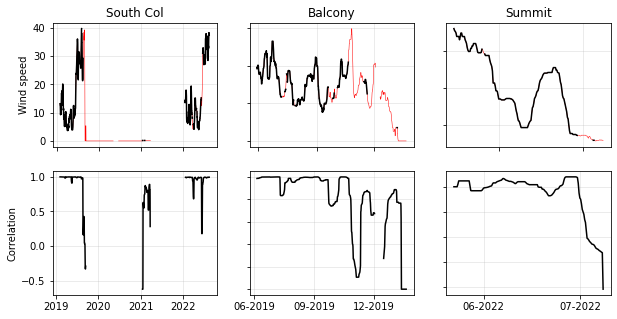

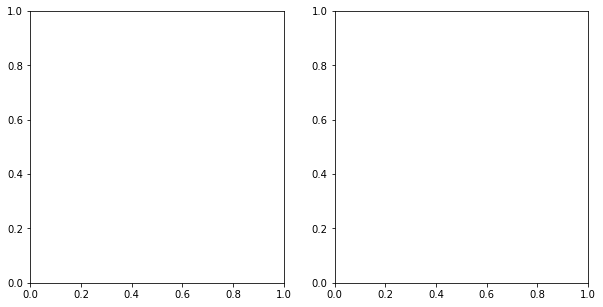

In [7]:
# Create some example plots to visualize data. Can be commented out if using different data or not needed.

p1t=pd.to_datetime(['2019-01-01','2021-01-01'])
p2t=pd.to_datetime(['2021-09-01','2023-01-01'])
p1=full[(full.index > p1t[0])& (full.index < p1t[1])]
p2=full[(full.index > p2t[0])& (full.index < p2t[1])]

import matplotlib.dates as mdates

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3)

dt=full["scol_max2"].rolling(4*7).median()
ax1.plot(dt,color='red',linewidth = 0.5)
dtgood= dt; dtgood[full["scol_mask"]==1]=np.nan;
ax1.plot(dtgood,color='black')
ax1.grid(linewidth = 0.5, alpha = 0.5)
ax1.set_ylabel('Wind speed')
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.set_title('South Col')

ax4.plot((full["scol_max1"].rolling(4*7).corr(full["scol_max2"],method='spearman').rolling(4*7).median()),color='black')
ax4.grid(linewidth = 0.5, alpha = 0.5)
ax4.set_ylabel('Correlation')
ax4.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

dt=p1["balcony_max1"].rolling(4*7).median()
ax2.plot(dt,color='red',linewidth = 0.5)
dtgood= dt; dtgood[p1["balcony_mask"]==1]=np.nan;
ax2.plot(dtgood,color='black')
ax2.grid(linewidth = 0.5, alpha = 0.5)
ax2.set_ylabel('Wind speed')
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax2.set_title('Balcony')

ax5.plot((p1["balcony_max1"].rolling(4*7).corr(p1["balcony_max2"],method='spearman').rolling(4*7).median()),color='black')
ax5.grid(linewidth = 0.5, alpha = 0.5)
ax5.set_ylabel('Correlation')
ax5.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax5.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))

dt=p2["summit_max2"].rolling(4*7).median()
ax3.plot(dt,color='red',linewidth = 0.5)
dtgood= dt; dtgood[p2["summit_mask"]==1]=np.nan;
ax3.plot(dtgood,color='black')
ax3.grid(linewidth = 0.5, alpha = 0.5)
ax3.set_ylabel('Wind speed')
ax3.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax3.set_title('Summit')


ax6.plot((p2["summit_max1"].rolling(4*7).corr(p2["summit_max2"],method='spearman').rolling(4*7).median()),color='black')
ax6.grid(linewidth = 0.5, alpha = 0.5)
ax6.set_ylabel('Correlation')
ax6.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax6.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))

for ax in fig.get_axes():
    ax.label_outer()
    
plt.show()


fig, ((ax1, ax2)) = plt.subplots(1, 2)



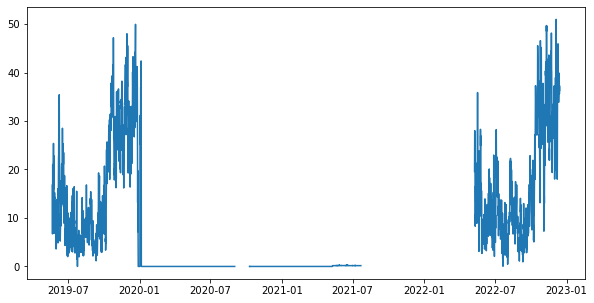

In [8]:
# Regress based on wind direction to create 'synthetic' summit dataset from longer timeseries of lower elevation data. 
# This is effectively a linear correction of the filtered datasets
from matplotlib import cm
import statsmodels.api as sm

#Define inclusion wind angles
minwind=230
maxwind=320


slope=[0]
intercept=[0]

slope_unc=[0]
intercept_unc=[0]

id=0

wdfilt=full[(full["wdERA5"]>minwind) & (full["wdERA5"]<maxwind)]
wdfilt=wdfilt.mask(full["scol_mask"]==1)
wdfilt=wdfilt.mask(full["summit_mask"]==1)

varx=wdfilt["summit_max1"]
vary=wdfilt["scol_max2"]

mask = ~np.isnan(varx) & ~np.isnan(vary)
x = sm.add_constant(varx[mask])
model = sm.OLS(vary[mask],x)
results = model.fit()
slope[id]=results.params[1]
intercept[id]=results.params[0]
slope_unc[id]=results.bse[1]
intercept_unc[id]=results.bse[0]

full["synthetic_summit_avg"]=full["scol_max2"]
plt.plot(full["synthetic_summit_avg"]);plt.show()
tempsummit = full["synthetic_summit_avg"]
tempsummit=tempsummit/slope[0]+intercept[0]
full["synthetic_summit_avg"]=tempsummit

full["synthetic_summit_max"]=full["scol_max2"]
tempsummit = full["synthetic_summit_max"]
tempsummit=tempsummit/(slope[0]+slope_unc[0])+(intercept[0]+intercept_unc[0])
full["synthetic_summit_max"]=tempsummit

full["synthetic_summit_min"]=full["scol_max2"]
tempsummit = full["synthetic_summit_min"]
tempsummit=tempsummit/(slope[0]-slope_unc[0])+(intercept[0]-intercept_unc[0])
full["synthetic_summit_min"]=tempsummit

full["synthetic_summit_avg"]=full["synthetic_summit_avg"].mask(full["scol_mask"]==1)
full["synthetic_summit_min"]=full["synthetic_summit_min"].mask(full["scol_mask"]==1)
full["synthetic_summit_max"]=full["synthetic_summit_max"].mask(full["scol_mask"]==1)

p1=full[(full.index > p1t[0])& (full.index < p1t[1])]
p2=full[(full.index > p2t[0])& (full.index < p2t[1])]


# Potentially relevant plots, uncomment to generate them.

# dualcorrplot("Synthetic Summit","ERA5",24*7*2,24*7,full["synthetic_summit_avg"],full["wsERA5"],full.index)
# dualcorrplot("Synthetic Summit","ERA5",24*7*2,24*7,p1["synthetic_summit_avg"],p1["wsERA5"],p1.index)
# dualcorrplot("Synthetic Summit","ERA5",24*7*2,24*7,p2["synthetic_summit_avg"],p2["wsERA5"],p2.index)

# dualcorrplot("Synthetic Summit","GFS12h",24*7*2,24*7,full["synthetic_summit_avg"],full["ws12"],full.index)
# dualcorrplot("Synthetic Summit","GFS12h",24*7*2,24*7,p1["synthetic_summit_avg"],p1["ws12"],p1.index)
# dualcorrplot("Synthetic Summit","GFS12h",24*7*2,24*7,p2["synthetic_summit_avg"],p2["ws12"],p2.index)

# dualcorrplot("Synthetic Summit","MERRA",24*7*2,24*7,full["synthetic_summit_avg"],full["wsMERRA"],full.index)
# dualcorrplot("Synthetic Summit","MERRA",24*7*2,24*7,p1["synthetic_summit_avg"],p1["wsMERRA"],p1.index)
# dualcorrplot("Synthetic Summit","MERRA",24*7*2,24*7,p2["synthetic_summit_avg"],p2["wsMERRA"],p2.index)


# dualcorrplot("Synthetic Summit","GFS168h",24*7*2,24*7,full["synthetic_summit_avg"],full["ws168"],full.index)
# dualcorrplot("Synthetic Summit","GFS168h",24*7*2,24*7,p1["synthetic_summit_avg"],p1["ws168"],p1.index)
# dualcorrplot("Synthetic Summit","GFS168h",24*7*2,24*7,p2["synthetic_summit_avg"],p2["ws168"],p2.index)


# dualcorrplot("Synthetic Summit","GFS384h",24*7*2,24*7,full["synthetic_summit_avg"],full["ws384"],full.index)
# dualcorrplot("Synthetic Summit","GFS384h",24*7*2,24*7,p1["synthetic_summit_avg"],p1["ws384"],p1.index)
# dualcorrplot("Synthetic Summit","GFS384h",24*7*2,24*7,p2["synthetic_summit_avg"],p2["ws384"],p2.index)

In [9]:
## Define Model Output Statistics, Machine learning, and related plotting functions.

# Simple gridded plot
def MOSplot(data,model_corrected,time):
    fig=plt.figure()
    ax1=fig.add_subplot(211)
    ax1.plot(time,data,color='red',linewidth=0.5,label='Data')
    ax1.plot(time,model_corrected,color='black',linewidth=0.5,label='Model')
    ax1.grid(linewidth = 0.5, alpha = 0.5)
    ax1.set_ylabel("Wind speed (m/s)")
    plt.legend()
    
    ax2=fig.add_subplot(223)
    ax2.scatter(data,model_corrected,marker='+',linewidth=0.5,color='black',alpha=0.25)
    # ax2.plot(data,data,color='grey',linewidth=1,linestyle=':')
    ax2.grid(linewidth = 0.5, alpha = 0.5)
    ax2.set_ylabel("Model wind speed (m/s)")
    ax2.set_xlabel("Data wind speed (m/s)")
    
    ax3=fig.add_subplot(224)
    ax3.hexbin(data,model_corrected,bins=np.linspace(0,20),gridsize=50)
    # ax2.plot(range(0,round(varx[mask].max())),intercept[0]+range(0,round(varx[mask].max()))*slope[0], color="black")
    ax3.grid(linewidth = 0.5, alpha = 0.5)
    ax3.set_xlabel("Data wind speed (m/s)")
    plt.show()

#Plot of regression outputs
def regressplot(label1,label2,a,b,time):
    a.interpolate();b.interpolate()

    DF = pd.DataFrame()
    DF['a'] = a
    DF['b'] = b
    
    
    varx=DF['a']
    vary=DF['b']

    mask = ~np.isnan(varx) & ~np.isnan(vary)
    x = sm.add_constant(varx[mask])
    model = sm.OLS(vary[mask],x)
    results = model.fit()
    slope[id]=results.params[1]
    intercept[id]=results.params[0]
    slope_unc[id]=results.bse[1]
    intercept_unc[id]=results.bse[0]
    
    fig=plt.figure()
    ax1=fig.add_subplot(131)
    ax1.scatter(varx[mask],vary[mask],marker='+',color="grey")
    # plt.hexbin(varx[mask],vary[mask],bins=np.linspace(1,50),gridsize=50)


    ax1.plot(range(0,round(varx[mask].max())),intercept[0]+range(0,round(varx[mask].max()))*slope[0], color="black")
    ax1.grid(linewidth = 0.5, alpha = 0.5);
    
    ax2=fig.add_subplot(132)
    # ax2.scatter(varx[mask],vary[mask],marker='+',color="grey")
    plt.hexbin(varx[mask],vary[mask],bins=np.linspace(1,50),gridsize=50)


    ax2.plot(range(0,round(varx[mask].max())),intercept[0]+range(0,round(varx[mask].max()))*slope[0], color="black")
    ax2.grid(linewidth = 0.5, alpha = 0.5);
    
    ax3=fig.add_subplot(133)
    ax3.hexbin(varx[mask],vary[mask]-(intercept[0]+varx[mask]*slope[0]),bins=np.linspace(0,50),gridsize=50)
    ax1.set_ylabel("Wind speed "+label1+" (m/s)")
    ax2.set_xlabel("Wind speed "+label2+" (m/s)")
    
    plt.show()
    
# Compute the statistics of a model output statistcs fit
def MOSstats(data,model_corrected):
    #Calculate key statistics: R2, RMSE, resid skew, resid kurtosis, MAE, slope, intercept, NSE, KGE, correlation, relvar, bias
    varx=data
    vary=model_corrected
    stats=[0]*12

    mask = ~np.isnan(varx) & ~np.isnan(vary)
    x = sm.add_constant(varx[mask])
    model = sm.OLS(vary[mask],x)
    results = model.fit()
    
    stats[0]=results.rsquared
    # stats[1]=np.sqrt(results.mse_total)
    stats[1]=np.sqrt(np.mean((data - model_corrected)**2))
    stats[2]=skew(results.resid, axis=0, bias=True)
    stats[3]=kurtosis(results.resid, axis=0, bias=True)
    stats[4]= np.mean(abs(data - model_corrected))
    # stats[5]=results.params[1]
    # stats[6]=results.params[0]
        
    stats[7]=mynse(varx[mask],vary[mask]);

    kgeo=mykge(varx[mask],vary[mask])
    stats[8]=kgeo[0]
    stats[9]=kgeo[1]
    stats[10]=kgeo[2]
    stats[11]=kgeo[3]
    
    print('R2='+str(round(stats[0],2))+' RMSE='+str(round(stats[1],2))+' skew='+str(round(stats[2],2))+' kurtosis='+str(round(stats[3],2))+' MAE='+str(round(stats[4],2))+\
          # ' slope='+str(round(stats[5],2))+' intercept='+str(round(stats[6],2))+
          ' NSE='+str(round(stats[7],2))+' KGE='+str(round(stats[8],2))+' corr='+str(round(stats[9],2))+\
          ' relvar='+str(round(stats[10],2))+' bias='+str(round(stats[11],2)))

    return(stats)

#Linear regression calculation with test train split
def MOSlinregressTTS2(data_train,model_train,model_test,model_full):
    vary=data_train
    varx=model_train
    
    mask = ~np.isnan(varx) & ~np.isnan(vary)
    x = sm.add_constant(varx[mask])
    model = sm.OLS(vary[mask],x)
    results = model.fit()
        
    slope=results.params[0]
    intercept=results.params["const"]
    
    
    model_test=intercept+model_test*slope
    model_corrected=intercept+model_full*slope

#Simple mean bias correction
def MOSmeanbias(data,model):
    model_corrected = model+(data.mean()-model.mean())
    return(model_corrected)

#Simple mean bias correction with test and train split
def MOSmeanbiasTTS(data_train,model_train,model_test,model_full):
    model_corrected = model_full+(data_train.mean()-model_train.mean())
    model_test = model_test+(data_train.mean()-model_train.mean())
    return(model_test,model_corrected)

#Linear regression calculation with test train split
def MOSlinregressTTS(data_train,model_train,model_test,model_full):
    vary=data_train
    varx=model_train
    
    mask = ~np.isnan(varx) & ~np.isnan(vary)
    x = sm.add_constant(varx[mask])
    model = sm.OLS(vary[mask],x)
    results = model.fit()
        
    slope=results.params[1]
    intercept=results.params[0]
    
    
    model_test=intercept+model_test*slope
    model_corrected=intercept+model_full*slope
    return(model_test,model_corrected)

#Simple linear regression calculation
def MOSlinregress(data,model):
    vary=data
    varx=model
    
    mask = ~np.isnan(varx) & ~np.isnan(vary)
    x = sm.add_constant(varx[mask])
    model = sm.OLS(vary[mask],x)
    results = model.fit()
    slope=results.params[1]
    intercept=results.params[0]

    model_corrected=intercept+varx*slope
    return(model_corrected)

#Random forest based Machine Learning MOS with test train split
# single timeseries input (not multivariate)
def MOSML_RF(data_train,model_train,model_test,model_full):
    vary=np.array(data_train)
    varx=np.array(model_train)

    mask = ~np.isnan(varx) & ~np.isnan(vary)
    
    vary=vary[mask].reshape(-1, 1)
    varx=varx[mask].reshape(-1, 1)
    
    rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
    
    rf.fit(varx,vary)

    # Use the forest's predict method on the test data
    model_test[~np.isnan(model_test)] = rf.predict(np.array(model_test[~np.isnan(model_test)]).reshape(-1, 1))
    
    # Use the forest's predict method on the full data
    model_corrected=model_full
    model_corrected[~np.isnan(model_full)] = rf.predict(np.array(model_full[~np.isnan(model_full)]).reshape(-1, 1))

    return(model_test,model_corrected)

#Naive Bayes based Machine Learning MOS with test train split
# single timeseries input (not multivariate)
#Poor results, not recommended
def MOSML_NB(data_train,model_train,model_test,model_full):
    vary=np.array(data_train)
    varx=np.array(model_train)

    mask = ~np.isnan(varx) & ~np.isnan(vary)
    
    vary=vary[mask].reshape(-1, 1).astype('int')
    varx=varx[mask].reshape(-1, 1).astype('int')
    
    gp=GaussianNB()
    
    gp.fit(varx,vary)

    # Use the forest's predict method on the test data
    model_test[~np.isnan(model_test)] = gp.predict(np.array(model_test[~np.isnan(model_test)]).reshape(-1, 1))
    
    # Use the forest's predict method on the full data
    model_corrected=model_full
    model_corrected[~np.isnan(model_full)] = gp.predict(np.array(model_full[~np.isnan(model_full)]).reshape(-1, 1))

    return(model_test,model_corrected)

#Gaussian Process model based Machine Learning MOS with test train split
# single timeseries input (not multivariate)
#Poor results, not recommended
def MOSML_GP(data_train,model_train,model_test,model_full):
    vary=np.array(data_train)
    varx=np.array(model_train)

    mask = ~np.isnan(varx) & ~np.isnan(vary)
    
    vary=vary[mask].reshape(-1, 1).astype('int')
    varx=varx[mask].reshape(-1, 1).astype('int')
    
    gp=  GaussianProcessClassifier(1.0 * RBF(1.0), random_state = 42)
    
    gp.fit(varx,vary)

    # Use the forest's predict method on the test data
    model_test[~np.isnan(model_test)] = gp.predict(np.array(model_test[~np.isnan(model_test)]).reshape(-1, 1))
    
    # Use the forest's predict method on the full data
    model_corrected=model_full
    model_corrected[~np.isnan(model_full)] = gp.predict(np.array(model_full[~np.isnan(model_full)]).reshape(-1, 1))

    return(model_test,model_corrected)

#Neural network (Simple multilayer perceptron) based Machine Learning MOS with test train split
# single timeseries input (not multivariate)
#See MOSLK_NN2 for a modified neural net with better performance but slower computation
def MOSML_NN(data_train,model_train,model_test,model_full):
    vary=np.array(data_train)
    varx=np.array(model_train)

    mask = ~np.isnan(varx) & ~np.isnan(vary)
    
    vary=vary[mask].reshape(-1, 1).astype('int')
    varx=varx[mask].reshape(-1, 1).astype('int')
    
    nn=MLPClassifier(alpha=1, max_iter=1000, random_state = 42)
    
    nn.fit(varx,vary)

    # Use the forest's predict method on the test data
    model_test[~np.isnan(model_test)] = nn.predict(np.array(model_test[~np.isnan(model_test)]).reshape(-1, 1))
    
    # Use the forest's predict method on the full data
    model_corrected=model_full
    model_corrected[~np.isnan(model_full)] = nn.predict(np.array(model_full[~np.isnan(model_full)]).reshape(-1, 1))

    return(model_test,model_corrected)

#Neural network (Modified multilayer perceptron) based Machine Learning MOS with test train split
# single timeseries input (not multivariate)
def MOSML_NN2(data_train,model_train,model_test,model_full):
    vary=np.array(data_train)
    varx=np.array(model_train)

    mask = ~np.any(np.isnan(varx),axis=1) & ~np.isnan(vary)

    vary=vary[mask].reshape(-1, 1)
    varx=varx[mask]#.reshape(-1, 1)

    rf = MLPClassifier(activation='relu',alpha=0.0001,hidden_layer_sizes=(10,10,10,100,100,1000,1000,100,100,10,10,10), max_iter=1000, random_state = 42)

    rf.fit(varx,vary)

    # Use the forest's predict method on the test data
    model_testt=model_test.iloc[:,1]
    model_testt[~np.any(np.isnan(np.array(model_test)),axis=1)] = rf.predict(np.array(model_test[~np.any(np.isnan(np.array(model_test)),axis=1)]))#.reshape(-1, 1))

    # Use the forest's predict method on the full data
    model_correctedt=model_full.iloc[:,1]
    model_correctedt[~np.any(np.isnan(np.array(model_full)),axis=1)] = rf.predict(np.array(model_full[~np.any(np.isnan(np.array(model_full)),axis=1)]))#.reshape(-1, 1))

    return(model_testt,model_correctedt)

#ADA boost based Machine Learning MOS with test train split
# single timeseries input (not multivariate)
#Poor results, not recommended
def MOSML_ADA(data_train,model_train,model_test,model_full):
    vary=np.array(data_train)
    varx=np.array(model_train)

    mask = ~np.isnan(varx) & ~np.isnan(vary)
    
    vary=vary[mask].reshape(-1, 1).astype('int')
    varx=varx[mask].reshape(-1, 1).astype('int')
    
    ada= AdaBoostClassifier(random_state = 42)
    
    ada.fit(varx,vary)

    # Use the forest's predict method on the test data
    model_test[~np.isnan(model_test)] = ada.predict(np.array(model_test[~np.isnan(model_test)]).reshape(-1, 1))
    
    # Use the forest's predict method on the full data
    model_corrected=model_full
    model_corrected[~np.isnan(model_full)] = ada.predict(np.array(model_full[~np.isnan(model_full)]).reshape(-1, 1))

    return(model_test,model_corrected)

#Random Forest based Machine Learning MOS with test train split
# multivariate data input is acceptable
def MOSML_RF2(data_train,model_train,model_test,model_full):
    vary=np.array(data_train)
    varx=np.array(model_train)

    mask = ~np.any(np.isnan(varx),axis=1) & ~np.isnan(vary)

    vary=vary[mask].reshape(-1, 1)
    varx=varx[mask]#.reshape(-1, 1)

    rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

    rf.fit(varx,vary)

    # Use the forest's predict method on the test data
    model_testt=model_test.iloc[:,1]
    model_testt[~np.any(np.isnan(np.array(model_test)),axis=1)] = rf.predict(np.array(model_test[~np.any(np.isnan(np.array(model_test)),axis=1)]))#.reshape(-1, 1))

    # Use the forest's predict method on the full data
    model_correctedt=model_full.iloc[:,1]
    model_correctedt[~np.any(np.isnan(np.array(model_full)),axis=1)] = rf.predict(np.array(model_full[~np.any(np.isnan(np.array(model_full)),axis=1)]))#.reshape(-1, 1))

    return(model_testt,model_correctedt)

#Multiple linear regression based "Machine Learning" MOS with test train split
# single timeseries input (not multivariate)
#Poor results, not recommended
def MOSML_MLR(data_train,model_train,model_test,model_full):
    vary=np.array(data_train)
    varx=np.array(model_train)

    mask = ~np.any(np.isnan(varx),axis=1) & ~np.isnan(vary)

    vary=vary[mask].reshape(-1, 1)
    varx=varx[mask]#.reshape(-1, 1)

    regr = linear_model.LinearRegression()

    regr.fit(varx,vary)

    # Use the forest's predict method on the test data
    model_testt=model_test.iloc[:,1]
    model_testt[~np.any(np.isnan(np.array(model_test)),axis=1)] = regr.predict(np.array(model_test[~np.any(np.isnan(np.array(model_test)),axis=1)])).flatten()

    # Use the forest's predict method on the full data
    model_correctedt=model_full.iloc[:,1]
    model_correctedt[~np.any(np.isnan(np.array(model_full)),axis=1)] = regr.predict(np.array(model_full[~np.any(np.isnan(np.array(model_full)),axis=1)])).flatten()

    return(model_testt,model_correctedt)

# Updated plot of results
def MOSplot2(datafull,data,model_corrected,time):
    fig=plt.figure()
    
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    
    ax1.plot(time,model_corrected,color='red',linewidth=0.5,label='Prediction')
    ax1.grid(linewidth = 0.5, alpha = 0.5)
    ax1.set_ylabel("Probability of winds above threshold")
    ax1.fill_between(
        x= time, 
        y1= model_corrected, 
        color= "r",
        alpha= 0.2)
    
    
    ax2.plot(time,datafull,color='black',linewidth=0.5,label='Data')
    ax2.grid(linewidth = 0.5, alpha = 0.5)
    ax2.set_ylabel("Data wind speed (m/s)")
    # ax1.legend()
    # ax2.legend()
    plt.show()
    
    #Plot ROC curve
    mask = ~np.isnan(data) & ~np.isnan(model_corrected)
    
    RocCurveDisplay.from_predictions(
    data[mask],
    model_corrected[mask],
    name="t vs the rest",
    color="darkorange",
    )
    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

#Categorical machine learning MOS function with multivariate input
#Can be used with either the random forest ('RF') or Neural Network ('NN')
#Test train split is used
#Note the requirement for a threshold to control the categorical binarization
def categoricalML(full,f0,thresh,rollwin,varname,MLmethod):
    #Inputs: data array, predictor variables, wind threshold, rolling max window, variable name, method
    p1t=pd.to_datetime(['2019-01-01','2021-01-01'])
    p2t=pd.to_datetime(['2021-01-01','2023-01-01'])
    p1=full[(full.index > p1t[0])& (full.index < p1t[1])]
    p2=full[(full.index > p2t[0])& (full.index < p2t[1])]
    p1f0=f0[(f0.index > p1t[0])& (f0.index < p1t[1])]
    p2f0=f0[(f0.index > p2t[0])& (f0.index < p2t[1])]

    data_test=p2["synthetic_summit_avg"].ge(thresh).astype(int).rolling(rollwin,center=False).max(); data_test[pd.isna(p2["synthetic_summit_avg"])]=np.nan
    model_test=p2f0.iloc[:,1:-1]
    model_full=f0.iloc[:,1:-1]
    data_train=p1["synthetic_summit_avg"].ge(thresh).astype(int).rolling(rollwin,center=False).max() ; data_train[pd.isna(p1["synthetic_summit_avg"])]=np.nan
    model_train=p1f0.iloc[:,1:-1]
    
    if MLmethod=="RF":
        p2[varname+str(thresh)+"1"],full[varname+str(thresh)+"1"]=MOSML_RF2(data_train,model_train,model_test,model_full)
    elif MLmethod=="NN":
        p2[varname+str(thresh)+"1"],full[varname+str(thresh)+"1"]=MOSML_NN2(data_train,model_train,model_test,model_full)
        
    MOSplot2(p2["synthetic_summit_avg"],data_test,p2[varname+str(thresh)+"1"],p2.index)

    data_test=p1["synthetic_summit_avg"].ge(30).astype(int).rolling(rollwin,center=False).max() ; data_test[pd.isna(p1["synthetic_summit_avg"])]=np.nan
    model_test=p1f0.iloc[:,1:-1]
    model_full=f0.iloc[:,1:-1]
    data_train=p2["synthetic_summit_avg"].ge(30).astype(int).rolling(rollwin,center=False).max(); data_train[pd.isna(p2["synthetic_summit_avg"])]=np.nan
    model_train=p2f0.iloc[:,1:-1]
    
    if MLmethod=="RF":
        p1[varname+str(thresh)+"2"],full[varname+str(thresh)+"2"]=MOSML_RF2(data_train,model_train,model_test,model_full)
    elif MLmethod=="NN":
        p1[varname+str(thresh)+"2"],full[varname+str(thresh)+"2"]=MOSML_NN2(data_train,model_train,model_test,model_full)
        
    MOSplot2(p1["synthetic_summit_avg"],data_test,p1[varname+str(thresh)+"2"],p1.index)
    return(full)


#Updated categorical machine learning MOS function with multivariate input
#Can be used with either the random forest ('RF') or Neural Network ('NN')
#Test train split is NOT used - train on full timeseries
#Note the requirement for a threshold to control the categorical binarization
def categoricalML2(full,f0,real,thresh,rollwin):

    # data_test=p1["synthetic_summit_avg"].le(thresh).astype(int).rolling(rollwin,center=False).mean() ; data_test[pd.isna(p1["synthetic_summit_avg"])]=np.nan
    # model_test=p1f0.iloc[:,1:-1]
    model_full=real.iloc[:,1:-1]
    data_train=full["synthetic_summit_avg"].ge(thresh).astype(int).rolling(rollwin,center=False).max(); 
    data_train[pd.isna(full["synthetic_summit_avg"])]=np.nan
    model_train=f0.iloc[:,1:-1]

    vary=np.array(data_train)
    varx=np.array(model_train)

    mask = ~np.any(np.isnan(varx),axis=1) & ~np.isnan(vary)

    vary=vary[mask].reshape(-1, 1)
    varx=varx[mask]#.reshape(-1, 1)

    rf = RandomForestRegressor(n_estimators = 100, random_state = 5)

    rf.fit(varx,vary)

    # Use the forest's predict method on the full data
    prediction=real.iloc[:,1]
    prediction = rf.predict(np.array(model_full[~np.any(np.isnan(np.array(model_full)),axis=1)]))#.reshape(-1, 1))

        
    return(prediction)

#Simple multivariate Random Forest based continuous prediction
#Test train split is NOT used - train on full timeseries
def contiML2(full,f0,real):

    model_full=real.iloc[:,1:-1]
    data_train=full["synthetic_summit_avg"]; 
    data_train[pd.isna(full["synthetic_summit_avg"])]=np.nan
    model_train=f0.iloc[:,1:-1]

    vary=np.array(data_train)
    varx=np.array(model_train)

    mask = ~np.any(np.isnan(varx),axis=1) & ~np.isnan(vary)

    vary=vary[mask].reshape(-1, 1)
    varx=varx[mask]#.reshape(-1, 1)

    rf = RandomForestRegressor(n_estimators = 1000, random_state = 5)

    rf.fit(varx,vary)

    # Use the forest's predict method on the full data
    prediction=real.iloc[:,1]
    prediction = rf.predict(np.array(model_full[~np.any(np.isnan(np.array(model_full)),axis=1)]))#.reshape(-1, 1))

        
    return(prediction)

In [10]:
#Function to get real-time GFS data from the NCAR THREDDS server and compute all
# derivative variables used in the multivariatemachine learning
def getdatcurrent(offsettime):

    #Define latitude and longitude bounds. Note min and max can be the same for a point.
    maxlat=29
    minlat=27
    maxlon=88
    minlon=86

    #Define variables of interest (see full list below)
    varibls=['u-component_of_wind_isobaric', 'Temperature_isobaric', 'Ozone_Mixing_Ratio_isobaric',\
             'Vertical_velocity_pressure_isobaric', 'Relative_humidity_isobaric', 'v-component_of_wind_isobaric', 'Geopotential_height_isobaric',\
             'Cloud_mixing_ratio_isobaric', 'Absolute_vorticity_isobaric']

    url = "https://thredds.ucar.edu/thredds/dodsC/grib/NCEP/GFS/Global_0p25deg/TwoD"
    ds = xr.open_dataset(url)
    # data2=ds[varibls].sel(lon=np.arange(minlon, maxlon+0.001, 0.25), lat=np.arange(minlat, maxlat+0.001, 0.25),\
    #                       isobaric=[3.00e+04, 3.50e+04, 4.00e+04], isobaric1=[30000.,  35000.,  40000],timeOffset=[offsettime])
    
    
    # print(ds[varibls])
    data2=ds[varibls].sel(lon=np.arange(minlon, maxlon+0.001, 0.25), lat=np.arange(minlat, maxlat+0.001, 0.25),\
                      isobaric=[3.00e+04, 3.50e+04, 4.00e+04], isobaric1=[30000.,  35000.,  40000])#,validtime2Offset=[offsettime])
    if 'validtime1Offset' in data2.coords:
        data2=data2.rename({'validtime1Offset':'validtimeOffset'})
    if 'validtime2Offset' in data2.coords:
        data2=data2.rename({'validtime2Offset':'validtimeOffset'})
    if 'validtime3Offset' in data2.coords:
        data2=data2.rename({'validtime3Offset':'validtimeOffset'})
    if 'validtime4Offset' in data2.coords:
        data2=data2.rename({'validtime4Offset':'validtimeOffset'})
    if 'validtime5Offset' in data2.coords:
        data2=data2.rename({'validtime5Offset':'validtimeOffset'})
    
    data2=data2.sel(validtimeOffset=[offsettime])
    
        
        
    # print(data2)
    dat_current = pd.DataFrame();

    dat_current['timax']=pd.to_datetime(data2.coords['reftime'].values)+ timedelta(hours=offsettime);

    t1=np.array(data2.variables['Geopotential_height_isobaric'].values)

    dat_current['GPH300']=t1[:,:,0,4,4];
    dat_current['GPH350']=t1[:,:,1,4,4];
    dat_current['GPH400']=t1[:,:,2,4,4];

    dat_current['GPH300xgrad3']=t1[:,:,0,4,3]-t1[:,:,0,4,5];
    dat_current['GPH300xgrad9']=t1[:,:,0,4,1]-t1[:,:,0,4,8];
    dat_current['GPH300ygrad3']=t1[:,:,0,3,4]-t1[:,:,0,5,4];
    dat_current['GPH300ygrad9']=t1[:,:,0,1,4]-t1[:,:,0,8,4];

    dat_current['GPH350xgrad3']=t1[:,:,1,4,3]-t1[:,:,1,4,5];
    dat_current['GPH350xgrad9']=t1[:,:,1,4,1]-t1[:,:,1,4,8];
    dat_current['GPH350ygrad3']=t1[:,:,1,3,4]-t1[:,:,1,5,4];
    dat_current['GPH350ygrad9']=t1[:,:,1,1,4]-t1[:,:,1,8,4];

    dat_current['GPH400xgrad3']=t1[:,:,2,4,3]-t1[:,:,2,4,5];
    dat_current['GPH400xgrad9']=t1[:,:,2,4,1]-t1[:,:,2,4,8];
    dat_current['GPH400ygrad3']=t1[:,:,2,3,4]-t1[:,:,2,5,4];
    dat_current['GPH400ygrad9']=t1[:,:,2,1,4]-t1[:,:,2,8,4];

    dat_current['GPHzgrad1']=t1[:,:,0,4,4]-t1[:,:,1,4,4];
    dat_current['GPHzgrad2']=t1[:,:,1,4,4]-t1[:,:,2,4,4];
    dat_current['GPHzgrad3']=t1[:,:,0,4,4]-t1[:,:,2,4,4];

    dat_current['GPHzgrad1m']=np.mean(np.mean(t1[:,:,0,:,:],axis=3),axis=2)-np.mean(np.mean(t1[:,:,1,:,:],axis=3),axis=2);
    dat_current['GPHzgrad2m']=np.mean(np.mean(t1[:,:,1,:,:],axis=3),axis=2)-np.mean(np.mean(t1[:,:,2,:,:],axis=3),axis=2);
    dat_current['GPHzgrad3m']=np.mean(np.mean(t1[:,:,0,:,:],axis=3),axis=2)-np.mean(np.mean(t1[:,:,2,:,:],axis=3),axis=2);

    GPHratio=(t1[:,:,0,4,4]-8849)/(t1[:,:,0,4,4]-t1[:,:,1,4,4]);
    GPHratio=np.squeeze(GPHratio)

    t1=np.array(data2.variables['Relative_humidity_isobaric'].values)

    dat_current['RH300']=t1[:,:,0,4,4];
    dat_current['RH350']=t1[:,:,1,4,4];
    dat_current['RH400']=t1[:,:,2,4,4];

    dat_current['RHsummit']=(1-GPHratio)*np.squeeze(t1[:,:,0,4,4])+GPHratio*np.squeeze(t1[:,:,1,4,4])

    t1=np.array(data2.variables['Cloud_mixing_ratio_isobaric'].values)

    dat_current['CLWMR300']=t1[:,:,0,4,4];
    dat_current['CLWMR350']=t1[:,:,1,4,4];
    dat_current['CLWMR400']=t1[:,:,2,4,4];

    dat_current['CLWMRsummit']=(1-GPHratio)*np.squeeze(t1[:,:,0,4,4])+GPHratio*np.squeeze(t1[:,:,1,4,4])

    t1=np.array(data2.variables['Vertical_velocity_pressure_isobaric'].values)

    dat_current['VertVelo300']=t1[:,:,0,4,4];
    dat_current['VertVelo350']=t1[:,:,1,4,4];
    dat_current['VertVelo400']=t1[:,:,2,4,4];

    dat_current['VertVelosummit']=(1-GPHratio)*np.squeeze(t1[:,:,0,4,4])+GPHratio*np.squeeze(t1[:,:,1,4,4])

    t1=np.array(data2.variables['Absolute_vorticity_isobaric'].values)

    dat_current['AbsVort300']=t1[:,:,0,4,4];
    dat_current['AbsVort350']=t1[:,:,1,4,4];
    dat_current['AbsVort400']=t1[:,:,2,4,4];

    dat_current['AbsVortsummit']=(1-GPHratio)*np.squeeze(t1[:,:,0,4,4])+GPHratio*np.squeeze(t1[:,:,1,4,4])

    t1=np.array(data2.variables['Ozone_Mixing_Ratio_isobaric'].values)

    dat_current['O3MX300']=t1[:,:,0,4,4];
    dat_current['O3MX350']=t1[:,:,1,4,4];
    dat_current['O3MX400']=t1[:,:,2,4,4];

    dat_current['O3MXsummit']=(1-GPHratio)*np.squeeze(t1[:,:,0,4,4])+GPHratio*np.squeeze(t1[:,:,1,4,4])


    t1=np.array(data2.variables['Temperature_isobaric'].values)

    dat_current['T300']=t1[:,:,0,4,4];
    dat_current['T350']=t1[:,:,1,4,4];
    dat_current['T400']=t1[:,:,2,4,4];
    dat_current['Tsummit']=(1-GPHratio)*np.squeeze(t1[:,:,0,4,4])+GPHratio*np.squeeze(t1[:,:,1,4,4])

    dat_current['T300xgrad3']=t1[:,:,0,4,3]-t1[:,:,0,4,5];
    dat_current['T300xgrad9']=t1[:,:,0,4,1]-t1[:,:,0,4,8];
    dat_current['T300ygrad3']=t1[:,:,0,3,4]-t1[:,:,0,5,4];
    dat_current['T300ygrad9']=t1[:,:,0,1,4]-t1[:,:,0,8,4];

    dat_current['T350xgrad3']=t1[:,:,1,4,3]-t1[:,:,1,4,5];
    dat_current['T350xgrad9']=t1[:,:,1,4,1]-t1[:,:,1,4,8];
    dat_current['T350ygrad3']=t1[:,:,1,3,4]-t1[:,:,1,5,4];
    dat_current['T350ygrad9']=t1[:,:,1,1,4]-t1[:,:,1,8,4];

    dat_current['T400xgrad3']=t1[:,:,2,4,3]-t1[:,:,2,4,5];
    dat_current['T400xgrad9']=t1[:,:,2,4,1]-t1[:,:,2,4,8];
    dat_current['T400ygrad3']=t1[:,:,2,3,4]-t1[:,:,2,5,4];
    dat_current['T400ygrad9']=t1[:,:,2,1,4]-t1[:,:,2,8,4];

    t1_summit = (1-np.tile(GPHratio[:, None, None], [1, 9, 9]))*t1[:,0,0,:,:]+\
        np.tile(GPHratio[:, None, None], [1, 9, 9])*t1[:,0,0,:,:];

    dat_current['Tsummitxgrad3']=t1_summit[:,4,3]-t1_summit[:,4,5];
    dat_current['Tsummitxgrad9']=t1_summit[:,4,1]-t1_summit[:,4,8];
    dat_current['Tsummitygrad3']=t1_summit[:,3,4]-t1_summit[:,5,4];
    dat_current['Tsummitygrad9']=t1_summit[:,1,4]-t1_summit[:,8,4];

    dat_current['Tzgrad1']=t1[:,:,0,4,4]-t1[:,:,1,4,4];
    dat_current['Tzgrad2']=t1[:,:,1,4,4]-t1[:,:,2,4,4];
    dat_current['Tzgrad3']=t1[:,:,0,4,4]-t1[:,:,2,4,4];

    dat_current['Tzgrad1m']=np.mean(np.mean(t1[:,:,0,:,:],axis=3),axis=2)-np.mean(np.mean(t1[:,:,1,:,:],axis=3),axis=2);
    dat_current['Tzgrad2m']=np.mean(np.mean(t1[:,:,1,:,:],axis=3),axis=2)-np.mean(np.mean(t1[:,:,2,:,:],axis=3),axis=2);
    dat_current['Tzgrad3m']=np.mean(np.mean(t1[:,:,0,:,:],axis=3),axis=2)-np.mean(np.mean(t1[:,:,2,:,:],axis=3),axis=2);


    t1=np.array(data2.variables['u-component_of_wind_isobaric'].values)

    dat_current['Uwind300']=t1[:,:,0,4,4];
    dat_current['Uwind350']=t1[:,:,1,4,4];
    dat_current['Uwind400']=t1[:,:,2,4,4];
    dat_current['Uwindsummit']=(1-GPHratio)*np.squeeze(t1[:,:,0,4,4])+GPHratio*np.squeeze(t1[:,:,1,4,4])

    dat_current['Uwind300xgrad3']=t1[:,:,0,4,3]-t1[:,:,0,4,5];
    dat_current['Uwind300xgrad9']=t1[:,:,0,4,1]-t1[:,:,0,4,8];
    dat_current['Uwind300ygrad3']=t1[:,:,0,3,4]-t1[:,:,0,5,4];
    dat_current['Uwind300ygrad9']=t1[:,:,0,1,4]-t1[:,:,0,8,4];

    dat_current['Uwind350xgrad3']=t1[:,:,1,4,3]-t1[:,:,1,4,5];
    dat_current['Uwind350xgrad9']=t1[:,:,1,4,1]-t1[:,:,1,4,8];
    dat_current['Uwind350ygrad3']=t1[:,:,1,3,4]-t1[:,:,1,5,4];
    dat_current['Uwind350ygrad9']=t1[:,:,1,1,4]-t1[:,:,1,8,4];

    dat_current['Uwind400xgrad3']=t1[:,:,2,4,3]-t1[:,:,2,4,5];
    dat_current['Uwind400xgrad9']=t1[:,:,2,4,1]-t1[:,:,2,4,8];
    dat_current['Uwind400ygrad3']=t1[:,:,2,3,4]-t1[:,:,2,5,4];
    dat_current['Uwind400ygrad9']=t1[:,:,2,1,4]-t1[:,:,2,8,4];

    t1_summit = (1-np.tile(GPHratio[:, None, None], [1, 9, 9]))*t1[:,0,0,:,:]+\
        np.tile(GPHratio[:, None, None], [1, 9, 9])*t1[:,0,0,:,:];

    u_summit = (1-np.tile(GPHratio[:, None, None], [1, 9, 9]))*t1[:,0,0,:,:]+\
        np.tile(GPHratio[:, None, None], [1, 9, 9])*t1[:,0,0,:,:];

    dat_current['Uwindsummitxgrad3']=t1_summit[:,4,3]-t1_summit[:,4,5];
    dat_current['Uwindsummitxgrad9']=t1_summit[:,4,1]-t1_summit[:,4,8];
    dat_current['Uwindsummitygrad3']=t1_summit[:,3,4]-t1_summit[:,5,4];
    dat_current['Uwindsummitygrad9']=t1_summit[:,1,4]-t1_summit[:,8,4];

    dat_current['Uwindzgrad1']=t1[:,:,0,4,4]-t1[:,:,1,4,4];
    dat_current['Uwindzgrad2']=t1[:,:,1,4,4]-t1[:,:,2,4,4];
    dat_current['Uwindzgrad3']=t1[:,:,0,4,4]-t1[:,:,2,4,4];

    dat_current['Uwindzgrad1m']=np.mean(np.mean(t1[:,:,0,:,:],axis=3),axis=2)-np.mean(np.mean(t1[:,:,1,:,:],axis=3),axis=2);
    dat_current['Uwindzgrad2m']=np.mean(np.mean(t1[:,:,1,:,:],axis=3),axis=2)-np.mean(np.mean(t1[:,:,2,:,:],axis=3),axis=2);
    dat_current['Uwindzgrad3m']=np.mean(np.mean(t1[:,:,0,:,:],axis=3),axis=2)-np.mean(np.mean(t1[:,:,2,:,:],axis=3),axis=2);


    t1=np.array(data2.variables['v-component_of_wind_isobaric'].values)

    dat_current['Vwind300']=t1[:,:,0,4,4];
    dat_current['Vwind350']=t1[:,:,1,4,4];
    dat_current['Vwind400']=t1[:,:,2,4,4];
    dat_current['Vwindsummit']=(1-GPHratio)*np.squeeze(t1[:,:,0,4,4])+GPHratio*np.squeeze(t1[:,:,1,4,4])

    dat_current['Vwind300xgrad3']=t1[:,:,0,4,3]-t1[:,:,0,4,5];
    dat_current['Vwind300xgrad9']=t1[:,:,0,4,1]-t1[:,:,0,4,8];
    dat_current['Vwind300ygrad3']=t1[:,:,0,3,4]-t1[:,:,0,5,4];
    dat_current['Vwind300ygrad9']=t1[:,:,0,1,4]-t1[:,:,0,8,4];

    dat_current['Vwind350xgrad3']=t1[:,:,1,4,3]-t1[:,:,1,4,5];
    dat_current['Vwind350xgrad9']=t1[:,:,1,4,1]-t1[:,:,1,4,8];
    dat_current['Vwind350ygrad3']=t1[:,:,1,3,4]-t1[:,:,1,5,4];
    dat_current['Vwind350ygrad9']=t1[:,:,1,1,4]-t1[:,:,1,8,4];

    dat_current['Vwind400xgrad3']=t1[:,:,2,4,3]-t1[:,:,2,4,5];
    dat_current['Vwind400xgrad9']=t1[:,:,2,4,1]-t1[:,:,2,4,8];
    dat_current['Vwind400ygrad3']=t1[:,:,2,3,4]-t1[:,:,2,5,4];
    dat_current['Vwind400ygrad9']=t1[:,:,2,1,4]-t1[:,:,2,8,4];

    t1_summit = (1-np.tile(GPHratio[:, None, None], [1, 9, 9]))*t1[:,0,0,:,:]+\
        np.tile(GPHratio[:, None, None], [1, 9, 9])*t1[:,0,0,:,:];

    v_summit = (1-np.tile(GPHratio[:, None, None], [1, 9, 9]))*t1[:,0,0,:,:]+\
        np.tile(GPHratio[:, None, None], [1, 9, 9])*t1[:,0,0,:,:];

    dat_current['Vwindsummitxgrad3']=t1_summit[:,4,3]-t1_summit[:,4,5];
    dat_current['Vwindsummitxgrad9']=t1_summit[:,4,1]-t1_summit[:,4,8];
    dat_current['Vwindsummitygrad3']=t1_summit[:,3,4]-t1_summit[:,5,4];
    dat_current['Vwindsummitygrad9']=t1_summit[:,1,4]-t1_summit[:,8,4];

    dat_current['Vwindzgrad1']=t1[:,:,0,4,4]-t1[:,:,1,4,4];
    dat_current['Vwindzgrad2']=t1[:,:,1,4,4]-t1[:,:,2,4,4];
    dat_current['Vwindzgrad3']=t1[:,:,0,4,4]-t1[:,:,2,4,4];

    dat_current['Vwindzgrad1m']=np.mean(np.mean(t1[:,:,0,:,:],axis=3),axis=2)-np.mean(np.mean(t1[:,:,1,:,:],axis=3),axis=2);
    dat_current['Vwindzgrad2m']=np.mean(np.mean(t1[:,:,1,:,:],axis=3),axis=2)-np.mean(np.mean(t1[:,:,2,:,:],axis=3),axis=2);
    dat_current['Vwindzgrad3m']=np.mean(np.mean(t1[:,:,0,:,:],axis=3),axis=2)-np.mean(np.mean(t1[:,:,2,:,:],axis=3),axis=2);


    uu=np.array(data2.variables['u-component_of_wind_isobaric'].values)
    vv=np.array(data2.variables['v-component_of_wind_isobaric'].values)

    def cart2pol(x, y):
        rho = np.sqrt(x**2 + y**2)
        phi = np.arctan2(y, x)
        return(rho, phi)

    wss,wdd = cart2pol(uu, vv)

    wdd = ((270-(180*wdd/3.141592)) % 360);

    wss_summit,wdd_summit = cart2pol(u_summit, v_summit)

    wdd_summit = ((270-(180*wdd_summit/3.141592)) % 360);



    t1=wdd

    dat_current['WD300']=t1[:,:,0,4,4];
    dat_current['WD350']=t1[:,:,1,4,4];
    dat_current['WD400']=t1[:,:,2,4,4];
    dat_current['WDsummit']=(1-GPHratio)*np.squeeze(t1[:,:,0,4,4])+GPHratio*np.squeeze(t1[:,:,1,4,4])

    dat_current['WD300xgrad3']=t1[:,:,0,4,3]-t1[:,:,0,4,5];
    dat_current['WD300xgrad9']=t1[:,:,0,4,1]-t1[:,:,0,4,8];
    dat_current['WD300ygrad3']=t1[:,:,0,3,4]-t1[:,:,0,5,4];
    dat_current['WD300ygrad9']=t1[:,:,0,1,4]-t1[:,:,0,8,4];

    dat_current['WD350xgrad3']=t1[:,:,1,4,3]-t1[:,:,1,4,5];
    dat_current['WD350xgrad9']=t1[:,:,1,4,1]-t1[:,:,1,4,8];
    dat_current['WD350ygrad3']=t1[:,:,1,3,4]-t1[:,:,1,5,4];
    dat_current['WD350ygrad9']=t1[:,:,1,1,4]-t1[:,:,1,8,4];

    dat_current['WD400xgrad3']=t1[:,:,2,4,3]-t1[:,:,2,4,5];
    dat_current['WD400xgrad9']=t1[:,:,2,4,1]-t1[:,:,2,4,8];
    dat_current['WD400ygrad3']=t1[:,:,2,3,4]-t1[:,:,2,5,4];
    dat_current['WD400ygrad9']=t1[:,:,2,1,4]-t1[:,:,2,8,4];

    t1_summit = wdd_summit

    dat_current['WDsummitxgrad3']=t1_summit[:,4,3]-t1_summit[:,4,5];
    dat_current['WDsummitxgrad9']=t1_summit[:,4,1]-t1_summit[:,4,8];
    dat_current['WDsummitygrad3']=t1_summit[:,3,4]-t1_summit[:,5,4];
    dat_current['WDsummitygrad9']=t1_summit[:,1,4]-t1_summit[:,8,4];

    dat_current['WDzgrad1']=t1[:,:,0,4,4]-t1[:,:,1,4,4];
    dat_current['WDzgrad2']=t1[:,:,1,4,4]-t1[:,:,2,4,4];
    dat_current['WDzgrad3']=t1[:,:,0,4,4]-t1[:,:,2,4,4];

    dat_current['WDzgrad1m']=np.mean(np.mean(t1[:,:,0,:,:],axis=3),axis=2)-np.mean(np.mean(t1[:,:,1,:,:],axis=3),axis=2);
    dat_current['WDzgrad2m']=np.mean(np.mean(t1[:,:,1,:,:],axis=3),axis=2)-np.mean(np.mean(t1[:,:,2,:,:],axis=3),axis=2);
    dat_current['WDzgrad3m']=np.mean(np.mean(t1[:,:,0,:,:],axis=3),axis=2)-np.mean(np.mean(t1[:,:,2,:,:],axis=3),axis=2);


    t1=wss

    dat_current['WS300']=t1[:,:,0,4,4];
    dat_current['WS350']=t1[:,:,1,4,4];
    dat_current['WS400']=t1[:,:,2,4,4];
    dat_current['WSsummit']=(1-GPHratio)*np.squeeze(t1[:,:,0,4,4])+GPHratio*np.squeeze(t1[:,:,1,4,4])

    dat_current['WS300xgrad3']=t1[:,:,0,4,3]-t1[:,:,0,4,5];
    dat_current['WS300xgrad9']=t1[:,:,0,4,1]-t1[:,:,0,4,8];
    dat_current['WS300ygrad3']=t1[:,:,0,3,4]-t1[:,:,0,5,4];
    dat_current['WS300ygrad9']=t1[:,:,0,1,4]-t1[:,:,0,8,4];

    dat_current['WS350xgrad3']=t1[:,:,1,4,3]-t1[:,:,1,4,5];
    dat_current['WS350xgrad9']=t1[:,:,1,4,1]-t1[:,:,1,4,8];
    dat_current['WS350ygrad3']=t1[:,:,1,3,4]-t1[:,:,1,5,4];
    dat_current['WS350ygrad9']=t1[:,:,1,1,4]-t1[:,:,1,8,4];

    dat_current['WS400xgrad3']=t1[:,:,2,4,3]-t1[:,:,2,4,5];
    dat_current['WS400xgrad9']=t1[:,:,2,4,1]-t1[:,:,2,4,8];
    dat_current['WS400ygrad3']=t1[:,:,2,3,4]-t1[:,:,2,5,4];
    dat_current['WS400ygrad9']=t1[:,:,2,1,4]-t1[:,:,2,8,4];

    t1_summit = wss_summit

    dat_current['WSsummitxgrad3']=t1_summit[:,4,3]-t1_summit[:,4,5];
    dat_current['WSsummitxgrad9']=t1_summit[:,4,1]-t1_summit[:,4,8];
    dat_current['WSsummitygrad3']=t1_summit[:,3,4]-t1_summit[:,5,4];
    dat_current['WSsummitygrad9']=t1_summit[:,1,4]-t1_summit[:,8,4];

    dat_current['WSzgrad1']=t1[:,:,0,4,4]-t1[:,:,1,4,4];
    dat_current['WSzgrad2']=t1[:,:,1,4,4]-t1[:,:,2,4,4];
    dat_current['WSzgrad3']=t1[:,:,0,4,4]-t1[:,:,2,4,4];

    dat_current['WSzgrad1m']=np.mean(np.mean(t1[:,:,0,:,:],axis=3),axis=2)-np.mean(np.mean(t1[:,:,1,:,:],axis=3),axis=2);
    dat_current['WSzgrad2m']=np.mean(np.mean(t1[:,:,1,:,:],axis=3),axis=2)-np.mean(np.mean(t1[:,:,2,:,:],axis=3),axis=2);
    dat_current['WSzgrad3m']=np.mean(np.mean(t1[:,:,0,:,:],axis=3),axis=2)-np.mean(np.mean(t1[:,:,2,:,:],axis=3),axis=2);

    return(dat_current)



In [11]:
#Get all relevant forecast times (uncomment to load from server, or use the following code box to load from saved file)

dat_current0=getdatcurrent(0)
dat_current24=getdatcurrent(24)
dat_current48=getdatcurrent(48)
dat_current72=getdatcurrent(72)
dat_current96=getdatcurrent(96)
dat_current120=getdatcurrent(120)
dat_current144=getdatcurrent(144)
dat_current168=getdatcurrent(168)
dat_current192=getdatcurrent(192)
dat_current216=getdatcurrent(216)
dat_current240=getdatcurrent(240)
dat_current264=getdatcurrent(264)
dat_current288=getdatcurrent(288)
dat_current312=getdatcurrent(312)
dat_current336=getdatcurrent(336)
dat_current360=getdatcurrent(360)
dat_current384=getdatcurrent(384)



<xarray.Dataset>
Dimensions:                              (reftime: 13, validtimeOffset: 1, isobaric: 3, lat: 9, lon: 9, isobaric1: 3)
Coordinates:
  * lat                                  (lat) float32 27.0 27.25 ... 28.75 29.0
  * lon                                  (lon) float32 86.0 86.25 ... 87.75 88.0
  * reftime                              (reftime) datetime64[ns] 2023-05-08 ...
  * validtimeOffset                      (validtimeOffset) float64 0.0
    validtime3                           (reftime, validtimeOffset) datetime64[ns] ...
  * isobaric                             (isobaric) float32 3e+04 3.5e+04 4e+04
  * isobaric1                            (isobaric1) float32 3e+04 3.5e+04 4e+04
Data variables:
    u-component_of_wind_isobaric         (reftime, validtimeOffset, isobaric, lat, lon) float32 ...
    Temperature_isobaric                 (reftime, validtimeOffset, isobaric, lat, lon) float32 ...
    Ozone_Mixing_Ratio_isobaric          (reftime, validtimeOffset, isobar

In [12]:
# Option to save and recover variables (forecasts)

# # Saving the objects:
with open('objs.pkl', 'wb') as f: 
    pickle.dump([dat_current0,\
        dat_current24,\
        dat_current48,\
        dat_current72,\
        dat_current96,\
        dat_current120,\
        dat_current144,\
        dat_current168,\
        dat_current192,\
        dat_current216,\
        dat_current240,\
        dat_current264,\
        dat_current288,\
        dat_current312,\
        dat_current336,\
        dat_current360,\
        dat_current384], f)

# # Loading saved timeseries from memory:
# with open('objs.pkl','rb') as f:  
#     dat_current0,\
#         dat_current24,\
#         dat_current48,\
#         dat_current72,\
#         dat_current96,\
#         dat_current120,\
#         dat_current144,\
#         dat_current168,\
#         dat_current192,\
#         dat_current216,\
#         dat_current240,\
#         dat_current264,\
#         dat_current288,\
#         dat_current312,\
#         dat_current336,\
#         dat_current360,\
#         dat_current384 = pickle.load(f)
    
# print(dat_current0)

In [13]:
#Define separate functions to pretrain the categorical MOS Random Forest model for a specific lead time and save it to a file
#
#And a second function (RFload) to load these pretrained models and apply them. This helps with portability and
# computational efficiency
def RFtrain(name,full,f0,real,thresh,rollwin):

    # data_test=p1["synthetic_summit_avg"].le(thresh).astype(int).rolling(rollwin,center=False).mean() ; data_test[pd.isna(p1["synthetic_summit_avg"])]=np.nan
    # model_test=p1f0.iloc[:,1:-1]
    # model_full=real.iloc[:,1:-1]
    data_train=full["synthetic_summit_avg"].ge(thresh).astype(int).rolling(rollwin,center=False).max(); 
    data_train[pd.isna(full["synthetic_summit_avg"])]=np.nan
    model_train=f0.iloc[:,1:-1]

    vary=np.array(data_train)
    varx=np.array(model_train)

    mask = ~np.any(np.isnan(varx),axis=1) & ~np.isnan(vary)

    vary=vary[mask].reshape(-1, 1)
    varx=varx[mask]#.reshape(-1, 1)

    rf = RandomForestRegressor(n_estimators = 1000, random_state = 5)

    rf.fit(varx,vary)

    # Use the forest's predict method on the full data
    # Save the trained model to a file
    with open('ML_models/'+name+'.pkl', 'wb') as f:
        pickle.dump(rf, f)
        
        
def RFload(name,full,f0,real,thresh,rollwin):

    model_full=real.iloc[:,1:-1]


    # Use the forest's predict method on the full data
    # Load the saved model from the file
    with open('ML_models/'+name+'.pkl', 'rb') as f:
        rf = pickle.load(f)
        
    # Use the forest's predict method on the full data
    prediction=real.iloc[:,1]
    prediction = rf.predict(np.array(model_full[~np.any(np.isnan(np.array(model_full)),axis=1)]))#.reshape(-1, 1))
    
    return(prediction)

#Uncomment below to perform training, else load from file directly below if pretrained.

# RFtrain('rf0_t20',full,f0,dat_current0,20,1)
# RFtrain('rf24_t20',full,f24,dat_current24,20,1)
# RFtrain('rf48_t20',full,f48,dat_current48,20,1)
# RFtrain('rf72_t20',full,f72,dat_current72,20,1)
# RFtrain('rf96_t20',full,f96,dat_current96,20,1)
# RFtrain('rf120_t20',full,f120,dat_current120,20,1)
# RFtrain('rf144_t20',full,f144,dat_current144,20,1)
# RFtrain('rf168_t20',full,f168,dat_current168,20,1)
# RFtrain('rf192_t20',full,f192,dat_current192,20,1)
# RFtrain('rf216_t20',full,f216,dat_current216,20,1)
# RFtrain('rf240_t20',full,f240,dat_current240,20,1)
# RFtrain('rf264_t20',full,f264,dat_current264,20,1)
# RFtrain('rf288_t20',full,f288,dat_current288,20,1)
# RFtrain('rf312_t20',full,f312,dat_current312,20,1)
# RFtrain('rf336_t20',full,f336,dat_current336,20,1)
# RFtrain('rf360_t20',full,f360,dat_current360,20,1)
# RFtrain('rf384_t20',full,f384,dat_current384,20,1)


# RFtrain('rf0_t30',full,f0,dat_current0,30,1)
# RFtrain('rf24_t30',full,f24,dat_current24,30,1)
# RFtrain('rf48_t30',full,f48,dat_current48,30,1)
# RFtrain('rf72_t30',full,f72,dat_current72,30,1)
# RFtrain('rf96_t30',full,f96,dat_current96,30,1)
# RFtrain('rf120_t30',full,f120,dat_current120,30,1)
# RFtrain('rf144_t30',full,f144,dat_current144,30,1)
# RFtrain('rf168_t30',full,f168,dat_current168,30,1)
# RFtrain('rf192_t30',full,f192,dat_current192,30,1)
# RFtrain('rf216_t30',full,f216,dat_current216,30,1)
# RFtrain('rf240_t30',full,f240,dat_current240,30,1)
# RFtrain('rf264_t30',full,f264,dat_current264,30,1)
# RFtrain('rf288_t30',full,f288,dat_current288,30,1)
# RFtrain('rf312_t30',full,f312,dat_current312,30,1)
# RFtrain('rf336_t30',full,f336,dat_current336,30,1)
# RFtrain('rf360_t30',full,f360,dat_current360,30,1)
# RFtrain('rf384_t30',full,f384,dat_current384,30,1)



In [14]:
#Load the pretrained data and perform MOS
rf0_t20=RFload('rf0_t20',full,f0,dat_current0,20,1)
rf24_t20=RFload('rf24_t20',full,f24,dat_current24,20,1)
rf48_t20=RFload('rf48_t20',full,f48,dat_current48,20,1)
rf72_t20=RFload('rf72_t20',full,f72,dat_current72,20,1)
rf96_t20=RFload('rf96_t20',full,f96,dat_current96,20,1)
rf120_t20=RFload('rf120_t20',full,f120,dat_current120,20,1)
rf144_t20=RFload('rf144_t20',full,f144,dat_current144,20,1)
rf168_t20=RFload('rf168_t20',full,f168,dat_current168,20,1)
rf192_t20=RFload('rf192_t20',full,f192,dat_current192,20,1)
rf216_t20=RFload('rf216_t20',full,f216,dat_current216,20,1)
rf240_t20=RFload('rf240_t20',full,f240,dat_current240,20,1)
rf264_t20=RFload('rf264_t20',full,f264,dat_current264,20,1)
rf288_t20=RFload('rf288_t20',full,f288,dat_current288,20,1)
rf312_t20=RFload('rf312_t20',full,f312,dat_current312,20,1)
rf336_t20=RFload('rf336_t20',full,f336,dat_current336,20,1)
rf360_t20=RFload('rf360_t20',full,f360,dat_current360,20,1)
rf384_t20=RFload('rf384_t20',full,f384,dat_current384,20,1)


rf0_t30=RFload('rf0_t30',full,f0,dat_current0,30,1)
rf24_t30=RFload('rf24_t30',full,f24,dat_current24,30,1)
rf48_t30=RFload('rf48_t30',full,f48,dat_current48,30,1)
rf72_t30=RFload('rf72_t30',full,f72,dat_current72,30,1)
rf96_t30=RFload('rf96_t30',full,f96,dat_current96,30,1)
rf120_t30=RFload('rf120_t30',full,f120,dat_current120,30,1)
rf144_t30=RFload('rf144_t30',full,f144,dat_current144,30,1)
rf168_t30=RFload('rf168_t30',full,f168,dat_current168,30,1)
rf192_t30=RFload('rf192_t30',full,f192,dat_current192,30,1)
rf216_t30=RFload('rf216_t30',full,f216,dat_current216,30,1)
rf240_t30=RFload('rf240_t30',full,f240,dat_current240,30,1)
rf264_t30=RFload('rf264_t30',full,f264,dat_current264,30,1)
rf288_t30=RFload('rf288_t30',full,f288,dat_current288,30,1)
rf312_t30=RFload('rf312_t30',full,f312,dat_current312,30,1)
rf336_t30=RFload('rf336_t30',full,f336,dat_current336,30,1)
rf360_t30=RFload('rf360_t30',full,f360,dat_current360,30,1)
rf384_t30=RFload('rf384_t30',full,f384,dat_current384,30,1)

In [28]:
#Plot the different lead times datasets 
# plt.plot(dat_current0['timax'],rf0_t20, color='black');plt.title('t=0, thresh=20 m/s'); plt.grid(alpha=0.3);plt.ylim([0, 1]);plt.show()
# plt.plot(dat_current24['timax'],rf24_t20, color='black');plt.title('t=24, thresh=20 m/s'); plt.grid(alpha=0.3);plt.ylim([0, 1]);plt.show()
# plt.plot(dat_current48['timax'],rf48_t20, color='black');plt.title('t=48, thresh=20 m/s'); plt.grid(alpha=0.3);plt.ylim([0, 1]);plt.show()
# plt.plot(dat_current72['timax'],rf72_t20, color='black');plt.title('t=72, thresh=20 m/s'); plt.grid(alpha=0.3);plt.ylim([0, 1]);plt.show()
# plt.plot(dat_current96['timax'],rf96_t20, color='black');plt.title('t=96, thresh=20 m/s'); plt.grid(alpha=0.3);plt.ylim([0, 1]);plt.show()
# plt.plot(dat_current120['timax'],rf120_t20, color='black');plt.title('t=120, thresh=20 m/s'); plt.grid(alpha=0.3);plt.ylim([0, 1]);plt.show()
# plt.plot(dat_current144['timax'],rf144_t20, color='black');plt.title('t=144, thresh=20 m/s'); plt.grid(alpha=0.3);plt.ylim([0, 1]);plt.show()
# plt.plot(dat_current168['timax'],rf168_t20, color='black');plt.title('t=168, thresh=20 m/s'); plt.grid(alpha=0.3);plt.ylim([0, 1]);plt.show()
# plt.plot(dat_current192['timax'],rf192_t20, color='black');plt.title('t=192, thresh=20 m/s'); plt.grid(alpha=0.3);plt.ylim([0, 1]);plt.show()
# plt.plot(dat_current216['timax'],rf216_t20, color='black');plt.title('t=216, thresh=20 m/s'); plt.grid(alpha=0.3);plt.ylim([0, 1]);plt.show()
# plt.plot(dat_current240['timax'],rf240_t20, color='black');plt.title('t=240, thresh=20 m/s'); plt.grid(alpha=0.3);plt.ylim([0, 1]);plt.show()
# plt.plot(dat_current264['timax'],rf264_t20, color='black');plt.title('t=264, thresh=20 m/s'); plt.grid(alpha=0.3);plt.ylim([0, 1]);plt.show()
# plt.plot(dat_current288['timax'],rf288_t20, color='black');plt.title('t=288, thresh=20 m/s'); plt.grid(alpha=0.3);plt.ylim([0, 1]);plt.show()
# plt.plot(dat_current312['timax'],rf312_t20, color='black');plt.title('t=312, thresh=20 m/s'); plt.grid(alpha=0.3);plt.ylim([0, 1]);plt.show()
# plt.plot(dat_current336['timax'],rf336_t20, color='black');plt.title('t=336, thresh=20 m/s'); plt.grid(alpha=0.3);plt.ylim([0, 1]);plt.show()
# plt.plot(dat_current360['timax'],rf360_t20, color='black');plt.title('t=360, thresh=20 m/s'); plt.grid(alpha=0.3);plt.ylim([0, 1]);plt.show()
# plt.plot(dat_current384['timax'],rf384_t20, color='black');plt.title('t=384, thresh=20 m/s'); plt.grid(alpha=0.3);plt.ylim([0, 1]);plt.show()

In [29]:
#Plot some datasets 

# plt.plot(dat_current0['timax'],rf0_t30, color='black');plt.title('t=0, thresh=30 m/s'); plt.grid(alpha=0.3);plt.ylim([0, 1]);plt.show()
# plt.plot(dat_current24['timax'],rf24_t30, color='black');plt.title('t=24, thresh=30 m/s'); plt.grid(alpha=0.3);plt.ylim([0, 1]);plt.show()
# plt.plot(dat_current48['timax'],rf48_t30, color='black');plt.title('t=48, thresh=30 m/s'); plt.grid(alpha=0.3);plt.ylim([0, 1]);plt.show()
# plt.plot(dat_current72['timax'],rf72_t30, color='black');plt.title('t=72, thresh=30 m/s'); plt.grid(alpha=0.3);plt.ylim([0, 1]);plt.show()
# plt.plot(dat_current96['timax'],rf96_t30, color='black');plt.title('t=96, thresh=30 m/s'); plt.grid(alpha=0.3);plt.ylim([0, 1]);plt.show()
# plt.plot(dat_current120['timax'],rf120_t30, color='black');plt.title('t=120, thresh=30 m/s'); plt.grid(alpha=0.3);plt.ylim([0, 1]);plt.show()
# plt.plot(dat_current144['timax'],rf144_t30, color='black');plt.title('t=144, thresh=30 m/s'); plt.grid(alpha=0.3);plt.ylim([0, 1]);plt.show()
# plt.plot(dat_current168['timax'],rf168_t30, color='black');plt.title('t=168, thresh=30 m/s'); plt.grid(alpha=0.3);plt.ylim([0, 1]);plt.show()
# plt.plot(dat_current192['timax'],rf192_t30, color='black');plt.title('t=192, thresh=30 m/s'); plt.grid(alpha=0.3);plt.ylim([0, 1]);plt.show()
# plt.plot(dat_current216['timax'],rf216_t30, color='black');plt.title('t=216, thresh=30 m/s'); plt.grid(alpha=0.3);plt.ylim([0, 1]);plt.show()
# plt.plot(dat_current240['timax'],rf240_t30, color='black');plt.title('t=240, thresh=30 m/s'); plt.grid(alpha=0.3);plt.ylim([0, 1]);plt.show()
# plt.plot(dat_current264['timax'],rf264_t30, color='black');plt.title('t=264, thresh=30 m/s'); plt.grid(alpha=0.3);plt.ylim([0, 1]);plt.show()
# plt.plot(dat_current288['timax'],rf288_t30, color='black');plt.title('t=288, thresh=30 m/s'); plt.grid(alpha=0.3);plt.ylim([0, 1]);plt.show()
# plt.plot(dat_current312['timax'],rf312_t30, color='black');plt.title('t=312, thresh=30 m/s'); plt.grid(alpha=0.3);plt.ylim([0, 1]);plt.show()
# plt.plot(dat_current336['timax'],rf336_t30, color='black');plt.title('t=336, thresh=30 m/s'); plt.grid(alpha=0.3);plt.ylim([0, 1]);plt.show()
# plt.plot(dat_current360['timax'],rf360_t30, color='black');plt.title('t=360, thresh=30 m/s'); plt.grid(alpha=0.3);plt.ylim([0, 1]);plt.show()
# plt.plot(dat_current384['timax'],rf384_t30, color='black');plt.title('t=384, thresh=30 m/s'); plt.grid(alpha=0.3);plt.ylim([0, 1]);plt.show()


In [17]:
#Define separate functions to pretrain the CONTINUOUS MOS Random Forest model for a specific lead time and save it to a file
#
#And a second function (RFload) to load these pretrained models and apply them. This helps with portability and
# computational efficiency
def RFtrain(name,full,f0,real,thresh,rollwin):

    # data_test=p1["synthetic_summit_avg"].le(thresh).astype(int).rolling(rollwin,center=False).mean() ; data_test[pd.isna(p1["synthetic_summit_avg"])]=np.nan
    # model_test=p1f0.iloc[:,1:-1]
    # model_full=real.iloc[:,1:-1]
    data_train=full["synthetic_summit_avg"]
    data_train[pd.isna(full["synthetic_summit_avg"])]=np.nan
    model_train=f0.iloc[:,1:-1]

    vary=np.array(data_train)
    varx=np.array(model_train)

    mask = ~np.any(np.isnan(varx),axis=1) & ~np.isnan(vary)

    vary=vary[mask].reshape(-1, 1)
    varx=varx[mask]#.reshape(-1, 1)

    rf = RandomForestRegressor(n_estimators = 1000, random_state = 5)

    rf.fit(varx,vary)

    # Use the forest's predict method on the full data
    # Save the trained model to a file
    with open('ML_models/'+name+'.pkl', 'wb') as f:
        pickle.dump(rf, f)
        
        
def RFload(name,full,f0,real,thresh,rollwin):

    model_full=real.iloc[:,1:-1]


    # Use the forest's predict method on the full data
    # Load the saved model from the file
    with open('ML_models/'+name+'.pkl', 'rb') as f:
        rf = pickle.load(f)
        
    # Use the forest's predict method on the full data
    prediction=real.iloc[:,1]
    prediction = rf.predict(np.array(model_full[~np.any(np.isnan(np.array(model_full)),axis=1)]))#.reshape(-1, 1))
    
    return(prediction)

#Uncomment below to perform training, else load from file directly below if pretrained.

# RFtrain('rf0_c',full,f0,dat_current0,20,1)
# RFtrain('rf24_c',full,f24,dat_current24,20,1)
# RFtrain('rf48_c',full,f48,dat_current48,20,1)
# RFtrain('rf72_c',full,f72,dat_current72,20,1)
# RFtrain('rf96_c',full,f96,dat_current96,20,1)
# RFtrain('rf120_c',full,f120,dat_current120,20,1)
# RFtrain('rf144_c',full,f144,dat_current144,20,1)
# RFtrain('rf168_c',full,f168,dat_current168,20,1)
# RFtrain('rf192_c',full,f192,dat_current192,20,1)
# RFtrain('rf216_c',full,f216,dat_current216,20,1)
# RFtrain('rf240_c',full,f240,dat_current240,20,1)
# RFtrain('rf264_c',full,f264,dat_current264,20,1)
# RFtrain('rf288_c',full,f288,dat_current288,20,1)
# RFtrain('rf312_c',full,f312,dat_current312,20,1)
# RFtrain('rf336_c',full,f336,dat_current336,20,1)
# RFtrain('rf360_c',full,f360,dat_current360,20,1)
# RFtrain('rf384_c',full,f384,dat_current384,20,1)



In [18]:
#Load the pretrained data and perform MOS
rf0_c=RFload('rf0_c',full,f0,dat_current0,20,1)
rf24_c=RFload('rf24_c',full,f24,dat_current24,20,1)
rf48_c=RFload('rf48_c',full,f48,dat_current48,20,1)
rf72_c=RFload('rf72_c',full,f72,dat_current72,20,1)
rf96_c=RFload('rf96_c',full,f96,dat_current96,20,1)
rf120_c=RFload('rf120_c',full,f120,dat_current120,20,1)
rf144_c=RFload('rf144_c',full,f144,dat_current144,20,1)
rf168_c=RFload('rf168_c',full,f168,dat_current168,20,1)
rf192_c=RFload('rf192_c',full,f192,dat_current192,20,1)
rf216_c=RFload('rf216_c',full,f216,dat_current216,20,1)
rf240_c=RFload('rf240_c',full,f240,dat_current240,20,1)
rf264_c=RFload('rf264_c',full,f264,dat_current264,20,1)
rf288_c=RFload('rf288_c',full,f288,dat_current288,20,1)
rf312_c=RFload('rf312_c',full,f312,dat_current312,20,1)
rf336_c=RFload('rf336_c',full,f336,dat_current336,20,1)
rf360_c=RFload('rf360_c',full,f360,dat_current360,20,1)
rf384_c=RFload('rf384_c',full,f384,dat_current384,20,1)


In [19]:
#Assemble seamless timeseries
timax = dat_current0['timax']

l=np.shape(timax)[0]-1

timaxt=timax[l]

timax=pd.to_datetime(\
[timaxt+timedelta(hours=0*6),timaxt+timedelta(hours=1*6),timaxt+timedelta(hours=2*6),timaxt+timedelta(hours=3*6),\
timaxt+timedelta(hours=4*6),timaxt+timedelta(hours=5*6),timaxt+timedelta(hours=6*6),timaxt+timedelta(hours=7*6),\
timaxt+timedelta(hours=8*6),timaxt+timedelta(hours=9*6),timaxt+timedelta(hours=10*6),timaxt+timedelta(hours=11*6),\
timaxt+timedelta(hours=12*6),timaxt+timedelta(hours=13*6),timaxt+timedelta(hours=14*6),timaxt+timedelta(hours=15*6),\
timaxt+timedelta(hours=16*6),timaxt+timedelta(hours=17*6),timaxt+timedelta(hours=18*6),timaxt+timedelta(hours=19*6),\
timaxt+timedelta(hours=20*6),timaxt+timedelta(hours=21*6),timaxt+timedelta(hours=22*6),timaxt+timedelta(hours=23*6),\
timaxt+timedelta(hours=24*6),timaxt+timedelta(hours=25*6),timaxt+timedelta(hours=26*6),timaxt+timedelta(hours=27*6),\
timaxt+timedelta(hours=28*6),timaxt+timedelta(hours=29*6),timaxt+timedelta(hours=30*6),timaxt+timedelta(hours=31*6),\
timaxt+timedelta(hours=32*6),timaxt+timedelta(hours=33*6),timaxt+timedelta(hours=34*6),timaxt+timedelta(hours=35*6),\
timaxt+timedelta(hours=36*6),timaxt+timedelta(hours=37*6),timaxt+timedelta(hours=38*6),timaxt+timedelta(hours=39*6),\
timaxt+timedelta(hours=40*6),timaxt+timedelta(hours=41*6),timaxt+timedelta(hours=42*6),timaxt+timedelta(hours=43*6),\
timaxt+timedelta(hours=44*6),timaxt+timedelta(hours=45*6),timaxt+timedelta(hours=46*6),timaxt+timedelta(hours=47*6),\
timaxt+timedelta(hours=48*6),timaxt+timedelta(hours=49*6),timaxt+timedelta(hours=50*6),timaxt+timedelta(hours=51*6),\
timaxt+timedelta(hours=52*6),timaxt+timedelta(hours=53*6),timaxt+timedelta(hours=54*6),timaxt+timedelta(hours=55*6),\
timaxt+timedelta(hours=56*6),timaxt+timedelta(hours=57*6),timaxt+timedelta(hours=58*6),timaxt+timedelta(hours=59*6),\
timaxt+timedelta(hours=60*6),timaxt+timedelta(hours=61*6),timaxt+timedelta(hours=62*6),timaxt+timedelta(hours=63*6),\
timaxt+timedelta(hours=64*6)])


co_cat_20 = [rf0_t20[l],\
             rf24_t20[l-3],rf24_t20[l-2],rf24_t20[l-1],rf24_t20[l],\
             rf48_t20[l-3],rf48_t20[l-2],rf48_t20[l-1],rf48_t20[l],\
             rf72_t20[l-3],rf72_t20[l-2],rf72_t20[l-1],rf72_t20[l],\
             rf96_t20[l-3],rf96_t20[l-2],rf96_t20[l-1],rf96_t20[l],\
             rf120_t20[l-3],rf120_t20[l-2],rf120_t20[l-1],rf120_t20[l],\
             rf144_t20[l-3],rf144_t20[l-2],rf144_t20[l-1],rf144_t20[l],\
             rf168_t20[l-3],rf168_t20[l-2],rf168_t20[l-1],rf168_t20[l],\
             rf192_t20[l-3],rf192_t20[l-2],rf192_t20[l-1],rf192_t20[l],\
             rf216_t20[l-3],rf216_t20[l-2],rf216_t20[l-1],rf216_t20[l],\
             rf240_t20[l-3],rf240_t20[l-2],rf240_t20[l-1],rf240_t20[l],\
             rf264_t20[l-3],rf264_t20[l-2],rf264_t20[l-1],rf264_t20[l],\
             rf288_t20[l-3],rf288_t20[l-2],rf288_t20[l-1],rf288_t20[l],\
             rf312_t20[l-3],rf312_t20[l-2],rf312_t20[l-1],rf312_t20[l],\
             rf336_t20[l-3],rf336_t20[l-2],rf336_t20[l-1],rf336_t20[l],\
             rf360_t20[l-3],rf360_t20[l-2],rf360_t20[l-1],rf360_t20[l],\
             rf384_t20[l-3],rf384_t20[l-2],rf384_t20[l-1],rf384_t20[l]]

co_cat_30 = [rf0_t30[l],\
             rf24_t30[l-3],rf24_t30[l-2],rf24_t30[l-1],rf24_t30[l],\
             rf48_t30[l-3],rf48_t30[l-2],rf48_t30[l-1],rf48_t30[l],\
             rf72_t30[l-3],rf72_t30[l-2],rf72_t30[l-1],rf72_t30[l],\
             rf96_t30[l-3],rf96_t30[l-2],rf96_t30[l-1],rf96_t30[l],\
             rf120_t30[l-3],rf120_t30[l-2],rf120_t30[l-1],rf120_t30[l],\
             rf144_t30[l-3],rf144_t30[l-2],rf144_t30[l-1],rf144_t30[l],\
             rf168_t30[l-3],rf168_t30[l-2],rf168_t30[l-1],rf168_t30[l],\
             rf192_t30[l-3],rf192_t30[l-2],rf192_t30[l-1],rf192_t30[l],\
             rf216_t30[l-3],rf216_t30[l-2],rf216_t30[l-1],rf216_t30[l],\
             rf240_t30[l-3],rf240_t30[l-2],rf240_t30[l-1],rf240_t30[l],\
             rf264_t30[l-3],rf264_t30[l-2],rf264_t30[l-1],rf264_t30[l],\
             rf288_t30[l-3],rf288_t30[l-2],rf288_t30[l-1],rf288_t30[l],\
             rf312_t30[l-3],rf312_t30[l-2],rf312_t30[l-1],rf312_t30[l],\
             rf336_t30[l-3],rf336_t30[l-2],rf336_t30[l-1],rf336_t30[l],\
             rf360_t30[l-3],rf360_t30[l-2],rf360_t30[l-1],rf360_t30[l],\
             rf384_t30[l-3],rf384_t30[l-2],rf384_t30[l-1],rf384_t30[l]]

co_con = [rf0_c[l],\
             rf24_c[l-3],rf24_c[l-2],rf24_c[l-1],rf24_c[l],\
             rf48_c[l-3],rf48_c[l-2],rf48_c[l-1],rf48_c[l],\
             rf72_c[l-3],rf72_c[l-2],rf72_c[l-1],rf72_c[l],\
             rf96_c[l-3],rf96_c[l-2],rf96_c[l-1],rf96_c[l],\
             rf120_c[l-3],rf120_c[l-2],rf120_c[l-1],rf120_c[l],\
             rf144_c[l-3],rf144_c[l-2],rf144_c[l-1],rf144_c[l],\
             rf168_c[l-3],rf168_c[l-2],rf168_c[l-1],rf168_c[l],\
             rf192_c[l-3],rf192_c[l-2],rf192_c[l-1],rf192_c[l],\
             rf216_c[l-3],rf216_c[l-2],rf216_c[l-1],rf216_c[l],\
             rf240_c[l-3],rf240_c[l-2],rf240_c[l-1],rf240_c[l],\
             rf264_c[l-3],rf264_c[l-2],rf264_c[l-1],rf264_c[l],\
             rf288_c[l-3],rf288_c[l-2],rf288_c[l-1],rf288_c[l],\
             rf312_c[l-3],rf312_c[l-2],rf312_c[l-1],rf312_c[l],\
             rf336_c[l-3],rf336_c[l-2],rf336_c[l-1],rf336_c[l],\
             rf360_c[l-3],rf360_c[l-2],rf360_c[l-1],rf360_c[l],\
             rf384_c[l-3],rf384_c[l-2],rf384_c[l-1],rf384_c[l]]



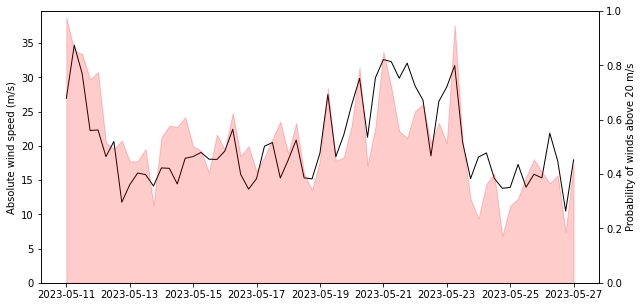

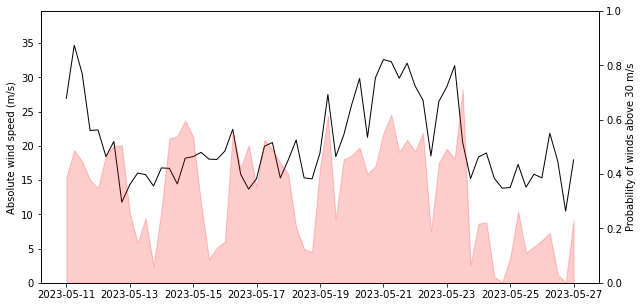

In [27]:
#Plot the final forecast
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(timax,co_con,color='k',linewidth=1);
ax1.set_ylabel("Absolute wind speed (m/s)")
ax1.set_ylim([0,max(co_con)+5])

ax2.plot(timax,co_cat_20,color='red',linewidth=0.01);
ax2.fill_between(
        x= timax, 
        y1= co_cat_20, 
        color= "r",
        alpha= 0.2)
ax2.set_ylabel("Probability of winds above 20 m/s")
ax2.set_ylim([0,1])

plt.show()

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(timax,co_con,color='k',linewidth=1);
ax1.set_ylabel("Absolute wind speed (m/s)")
ax1.set_ylim([0,max(co_con)+5])

ax2.plot(timax,co_cat_30,color='red',linewidth=0.01);
ax2.fill_between(
        x= timax, 
        y1= co_cat_30, 
        color= "r",
        alpha= 0.2)
ax2.set_ylabel("Probability of winds above 30 m/s")
ax2.set_ylim([0,1])

plt.show()